# Introduction
This notebook presents a comprehensive analysis of the Boston Housing dataset, a classic dataset in the field of machine learning and statistics. Our primary objectives include exploring the dataset, implementing various regression models (Unconstrained, Lasso, and Ridge regression), and examining the impact of missing data on these models. We also explore data imputation techniques, particularly using the nuclear norm method, to understand their effect on regression performance.

The analysis is structured as follows:
1. Data Exploration: Understanding the dataset's characteristics.
2. Regression Analysis: Implementing and comparing Unconstrained, Lasso, and Ridge regressions.
3. Handling Missing Data: Systematically introducing missing values and analyzing their impact.
4. Data Imputation: Employing nuclear norm for systematic data imputation.
5. Final Comparison: Evaluating the performance of regression models across different datasets (original, with missing values, and imputed).

Our goal is to gain insights into the robustness of these regression models in the face of incomplete data and to evaluate the effectiveness of different imputation methods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import calculating_functions as cf
import plotting_functions as pf

Lets load the dataset

In [2]:
# Importing the dataset
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataset = pd.read_csv('housing.csv', header=None, delimiter="\s+", names=column_names)

# print indexes where the values are missing
print(dataset[dataset.isnull().any(axis=1)].index.values)

dataset

[]


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


We see no missing values, so we can continue with the analysis, by plotting the distribution of each variable.

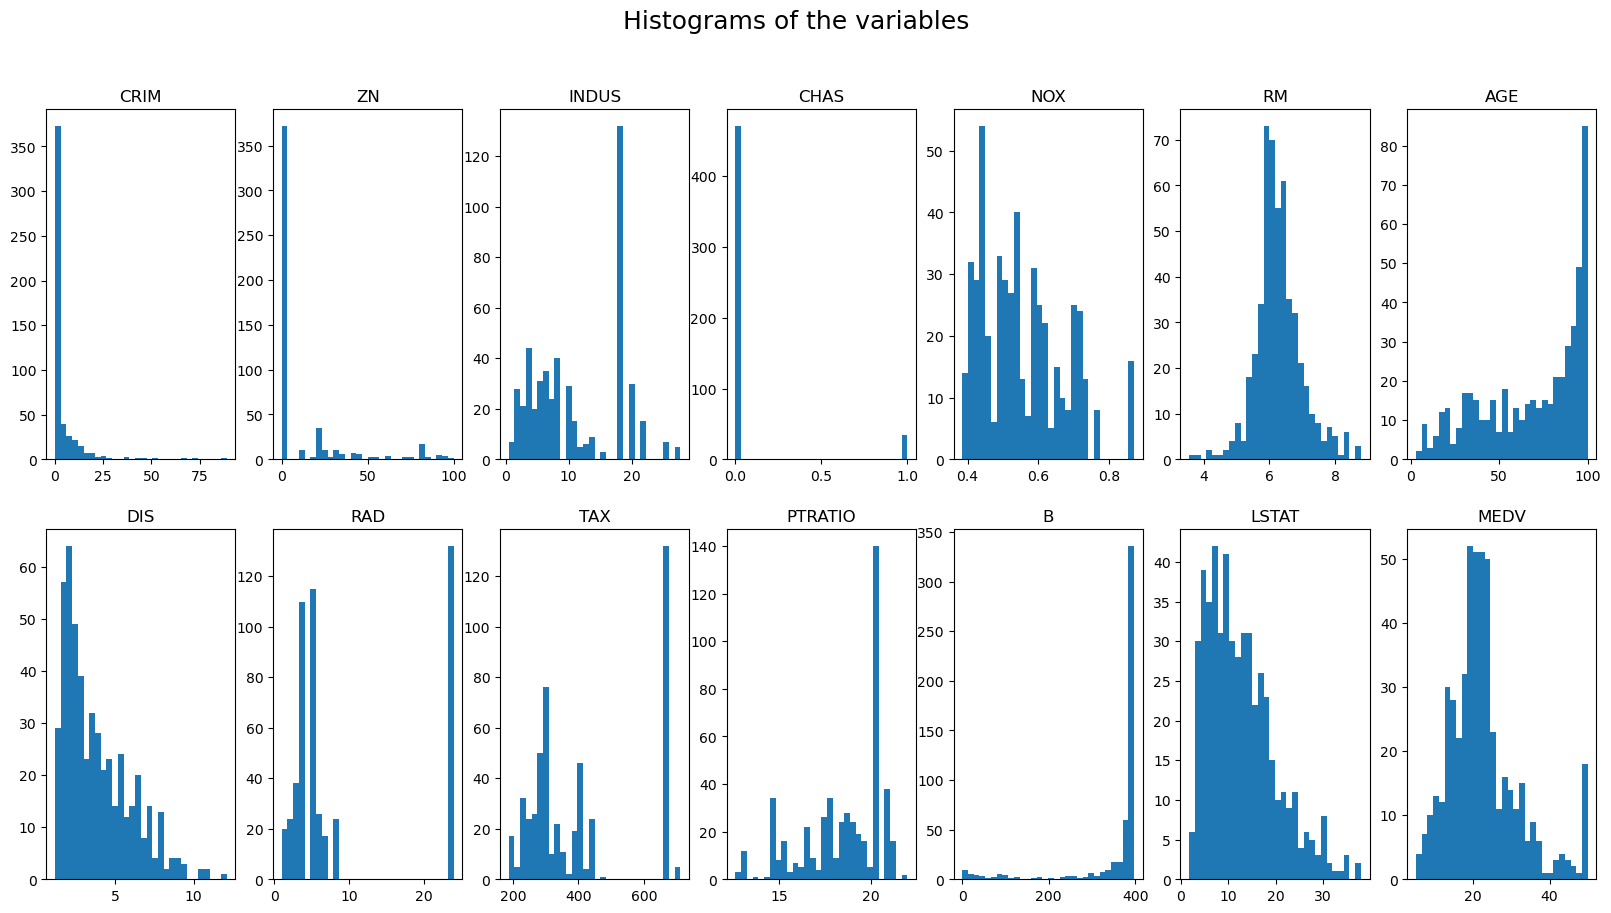

In [3]:
# create a 2x7 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20, 10))

# plot histograms of each all variables
for ax, col in zip(axes.flatten(), dataset.columns):
    ax.hist(dataset[col], bins=30)
    ax.set_title(col)

fig.suptitle('Histograms of the variables', fontsize=18)

plt.show()

We can see that the variables are not normally distributed. We also observe that each variable is on a different scale, so we will need to normalize them.
If we don't, the penalty that LASSO and Ridge regression apply to the coefficients will be biased towards the variables with the largest scale.
Lets plot the absolute correlation matrix to see if there is any correlation between the variables.

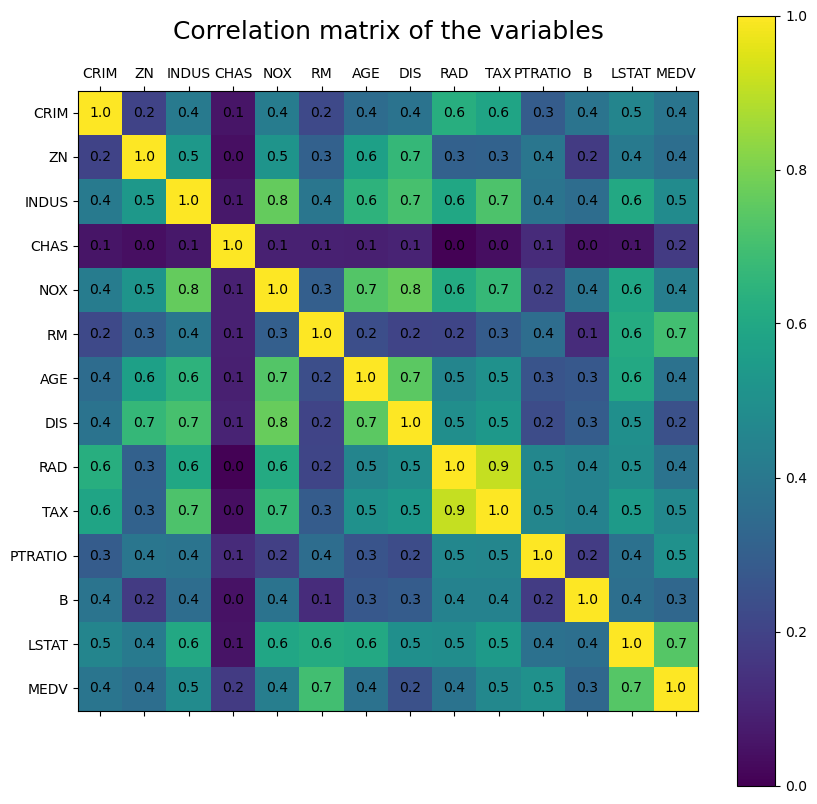

In [4]:
# plot correlation matrix
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr().abs(), vmin=0, vmax=1, interpolation='none')
ax.set_title('Correlation matrix of the variables', fontsize=18, pad=20)
for (i, j), z in np.ndenumerate(dataset.corr().abs()):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
# add a colorbar to the ax
plt.colorbar(cax, ax=ax)
ticks = np.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(dataset.columns)
ax.set_yticklabels(dataset.columns)
plt.show()

We can see that there is a strong correlation between TAX and RAD.
Lets continue by splitting the dataset into dependent and independent variables.
We will also keep the dummy variable CHAS, which is a categorical variable, seperately.

In [5]:
dep_var = dataset['MEDV']
dummy = dataset['CHAS']
indep_vars = dataset.drop(['MEDV','CHAS'], axis=1)

indep_vars

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


Lets plot each independent variable against the dependent variable to see if there is any correlation.

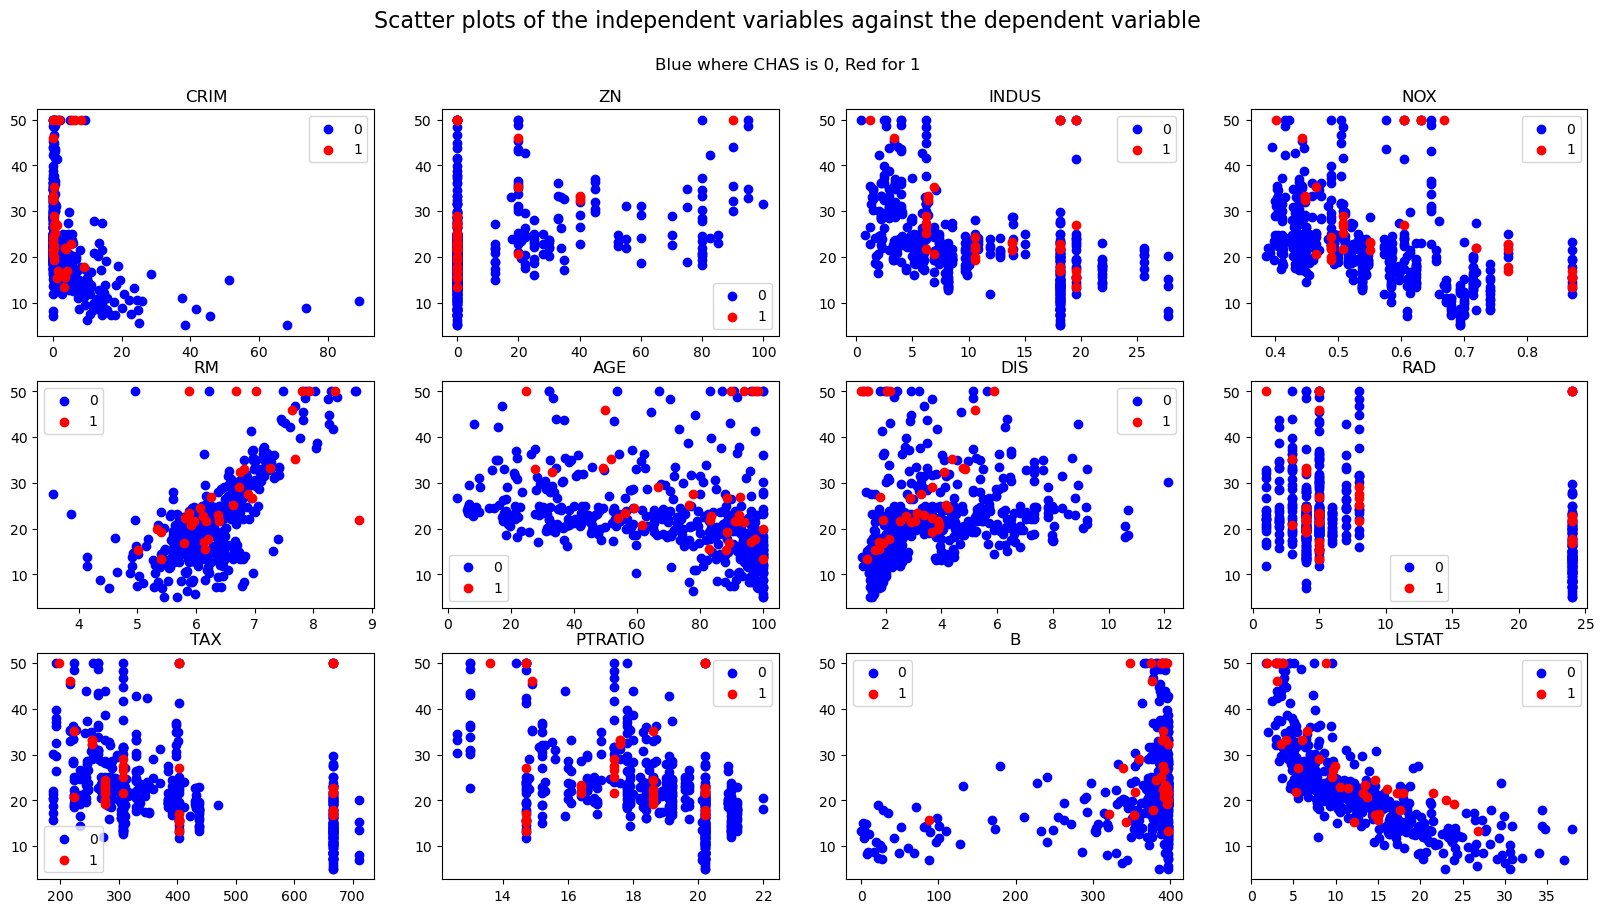

In [6]:
pf.indep_var_scatter_plot(indep_vars, dep_var, dummy, 'Scatter plots of the independent variables against the dependent variable', 'Blue where CHAS is 0, Red for 1')

We observe variables ZN, RAD, TAX, B have alot of outliers, this will affect the performance of the model, since LASSO can be sensitive to outliers.
Variable CRIM, whilst not having many outliers, the ones it has are very far from the rest of the data, so we need to take this into account.
Let's normalize the variables, except for the CHAS, which is a dummy encoded categorical variable.

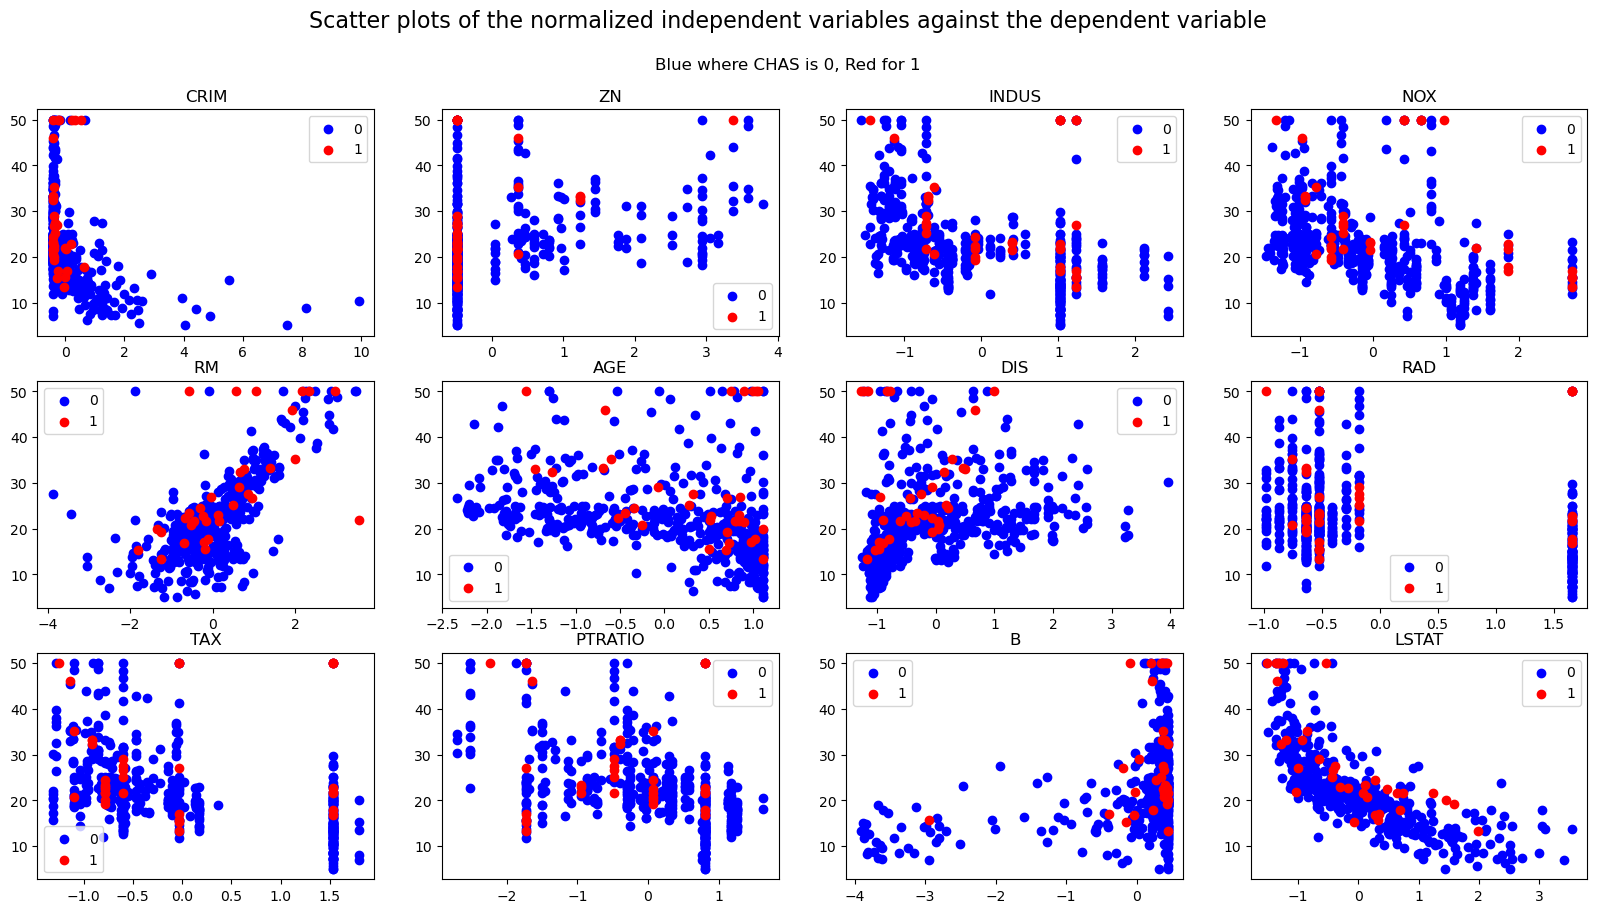

In [7]:
# normalize the variables
normalized_indep_vars = (indep_vars - indep_vars.mean()) / indep_vars.std()

pf.indep_var_scatter_plot(normalized_indep_vars, dep_var, dummy, 'Scatter plots of the normalized independent variables against the dependent variable', 'Blue where CHAS is 0, Red for 1')

From the Scatter Plots, we should also note that the CHAS variable, does introduce some variaton in the way the dependent variables is distributed, but not to the point where we can say that it have a significant impact on them. 
We can also conclude this by looking at the correlation heatmap, on the CHAS row. This could be due to the fact that we don't have enough data points for the CHAS variable where it is True.

## Regression Analysis
In this section, we delve into the core of our analysis by implementing three different types of regression models:

1. **Unconstrained Regression**: This is the basic form of linear regression without any regularization. It serves as our baseline for comparison.

2. **Lasso Regression (Least Absolute Shrinkage and Selection Operator)**: Lasso regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (i.e., models with fewer parameters).

3. **Ridge Regression**: Unlike Lasso, which can zero out coefficients entirely, Ridge regression will shrink them towards zero but never exactly to zero. It's particularly useful when dealing with multicollinearity or when you want to include all features in the model.

Each of these models has its strengths and weaknesses, which we will explore in the following sections. We will also use LaTeX to describe the mathematical formulations of these models for a clearer understanding.

Lets start by adding the dummy variable CHAS to the normalized independent variables. We will also split the dataset into train and test sets.

In [8]:
# add to normalized independent variables the dummy variable
normalized_indep_vars['CHAS'] = dummy

# split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_indep_vars, dep_var, test_size=0.2, random_state=0)
# Add bias term to the test set
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]

### Unconstrained Linear Regression
Unconstrained Linear Regression, often referred to as Ordinary Least Squares (OLS), seeks to minimize the sum of squared residuals. The optimization function is:
$$\min_{\beta} \sum_{i=1}^{N} (y_i - X_i\beta)^2$$
This is the simplest form of linear regression where $\beta$ represents the regression coefficients, $y_i$ the response variable, and $X_i$ the predictor variables. Unlike Lasso and Ridge, there is no regularization term in this formulation.

100%|██████████| 5000/5000 [00:00<00:00, 7474.03it/s]


MSE:  33.44897999769829
R2 score:  0.5892223849179836


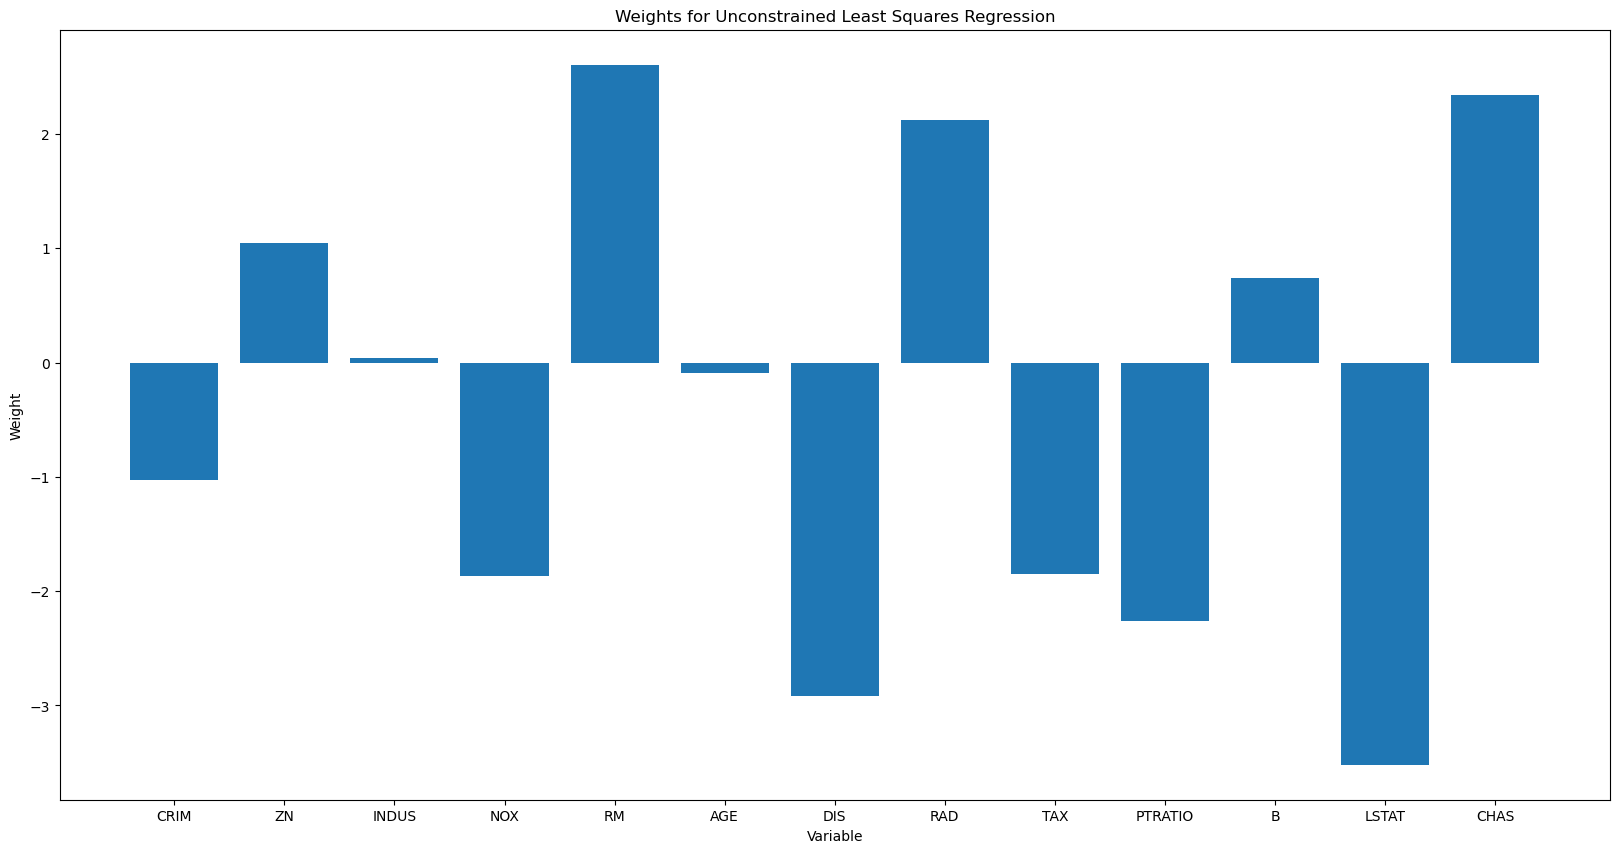

In [9]:
# run the unregularized linear regression
weights_least_squares = cf.linear_regression(X_train, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)

mse_least_squares, r2_least_squares = cf.fit_calculate(X_test_bias, y_test, weights_least_squares)

print('MSE: ', mse_least_squares)
print('R2 score: ', r2_least_squares)

# plot the values of the weights exluding the bias term
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

pf.bar_plot(axes, X_train.columns, weights_least_squares[1:], 'Weights for Unconstrained Least Squares Regression', 'Variable', 'Weight')

plt.show()

We can see that the ordinary least squares regression, does not perform too bad, but we can see that the weights of the variables are not very informative.

### Lasso Regression
The Lasso Regression (Least Absolute Shrinkage and Selection Operator) is formulated as an optimization problem where the goal is to minimize the following function:
$$\min_{\beta} \left\{ \frac{1}{2N} \sum_{i=1}^{N} (y_i - X_i\beta)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}$$
Here, $\beta$ represents the regression coefficients, $y_i$ the response variable, $X_i$ the predictor variables, $N$ the number of observations, $p$ the number of predictors, and $\lambda$ the regularization parameter that controls the amount of shrinkage applied to the coefficients.

Lasso Regression, while effective in feature selection and regularization, does not have a closed-form solution for multivariate variables. This necessitates the use of iterative methods like coordinate descent. A key aspect of Lasso is soft thresholding, which is central to its ability to set certain coefficients to zero, thereby achieving sparsity.

Soft thresholding operates by applying a threshold value to the coefficients, setting those below the threshold to zero. This process is crucial in Lasso's ability to perform feature selection and regularization simultaneously. However, the lack of a closed-form solution and the reliance on iterative methods can increase computational complexity, especially for large datasets.

In [10]:
# run the lasso regression
weight_lasso = cf.linear_regression(X_train, y_train, cf.gradient_lasso, alpha=2, epochs=100)

# Make predictions on the test set
mse_lasso , r2_lasso = cf.fit_calculate(X_test_bias, y_test, weight_lasso)

# print weights of the model
print(weight_lasso[1:])
print('MSE: ', mse_lasso)
print('R2 score: ', r2_lasso)


100%|██████████| 100/100 [00:00<00:00, 205.33it/s]

[ 0.          0.          0.          0.          1.96508838  0.
  0.          0.          0.         -1.20794292  0.         -3.27934997
  0.        ]
MSE:  41.51098052021692
R2 score:  0.4902152000155423


The lasso weights, whilst having a bigger MSE, are more informative than the ordinary least squares weights. The algorithm is able to keep only 3 variables in order to make predictions.
The reason for the bigger MSE, may be because of the outliers we highlighted earlier.

Let's now run the Lasso Regression for a range of lambda values, to see how the MSE and R2 score change.

In [11]:
lambdas = np.arange(0,5,0.05)

# call lasso for each lambda
weights_lasso = [cf.linear_regression(X_train, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas)]

# Make predictions on the test set
mse_lasso, r2_lasso = cf.fit_calculate(X_test_bias, y_test, weights_lasso)

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


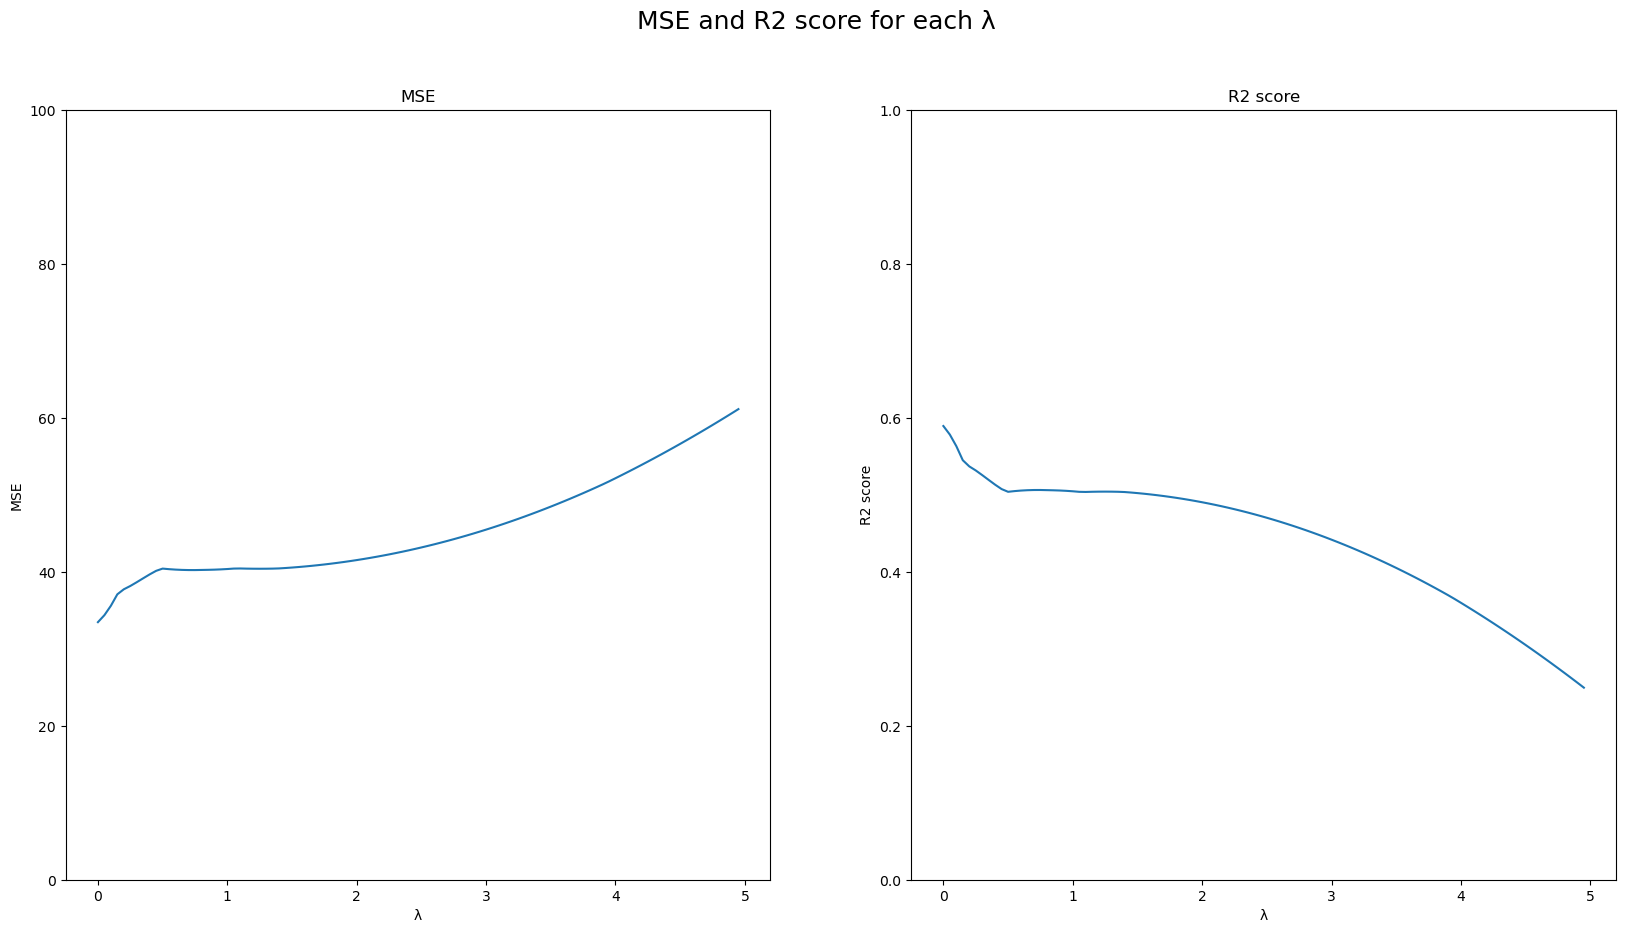

In [12]:
# plot the MSE and R2 score for each λ
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

pf.line_plot(axes[0], lambdas, mse_lasso, 'MSE', 'λ', 'MSE', y_lim=[0, 100])
pf.line_plot(axes[1], lambdas, r2_lasso, 'R2 score', 'λ', 'R2 score', y_lim=[0, 1])

fig.suptitle('MSE and R2 score for each λ', fontsize=18)

plt.show()

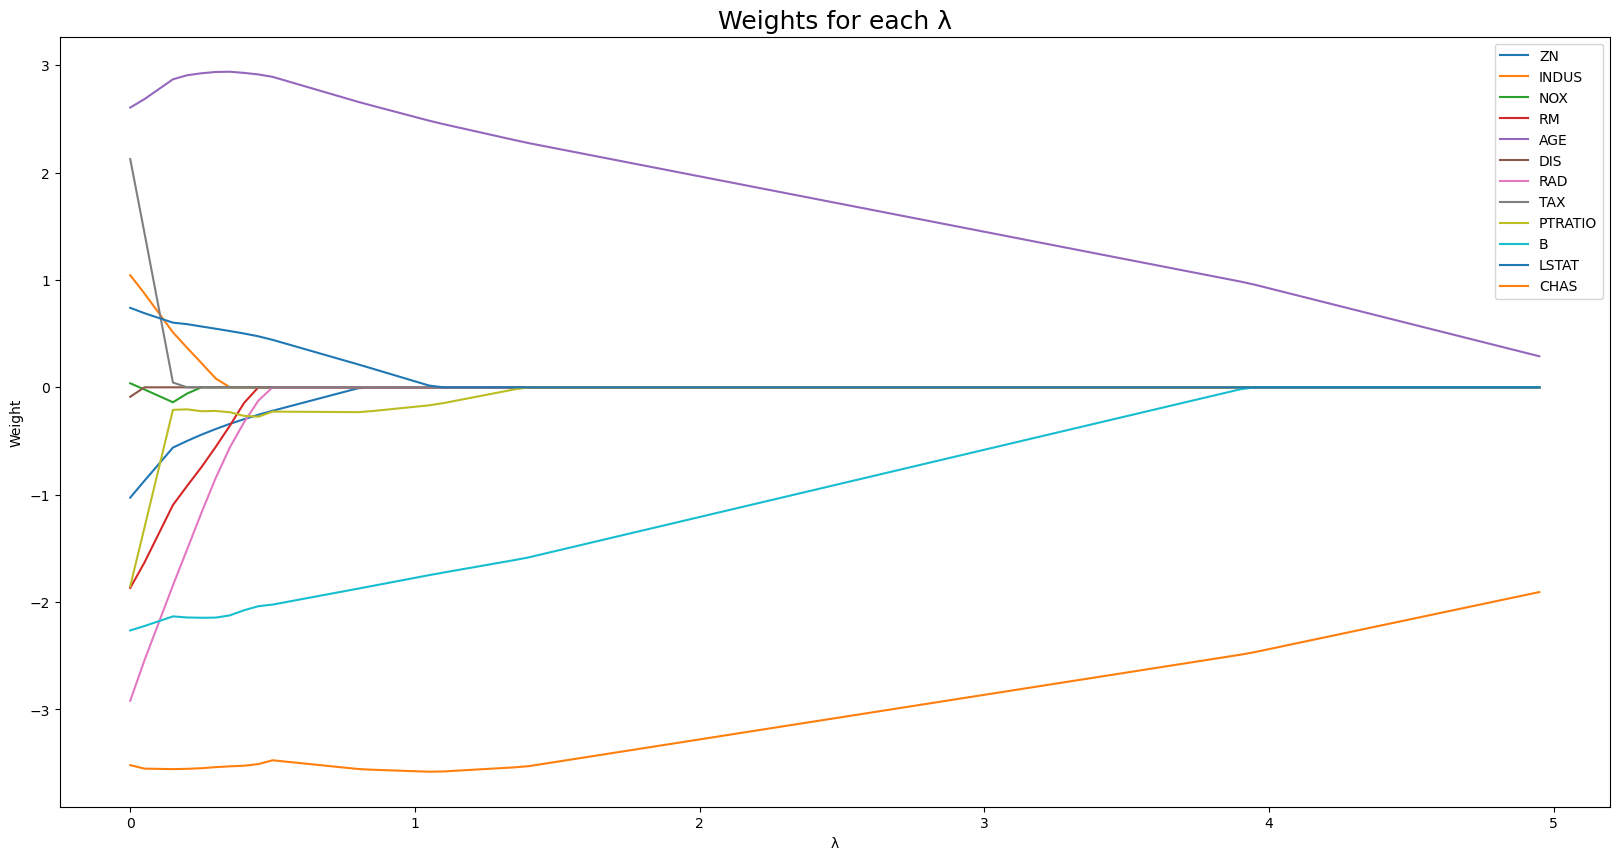

In [13]:
pf.lasso_weights_plot(weights_lasso, lambdas,X_train.columns, 'Weights for each λ', 'λ', 'Weight')

We can see that as the value of λ increases, the Lasso Regression penalizes more and more the coefficients of the variables that are not that important, and sets them to 0. The fact that most of the variables are set to 0, means that the algorithm is able to identify the most important variables, and keep them in order to make predictions.

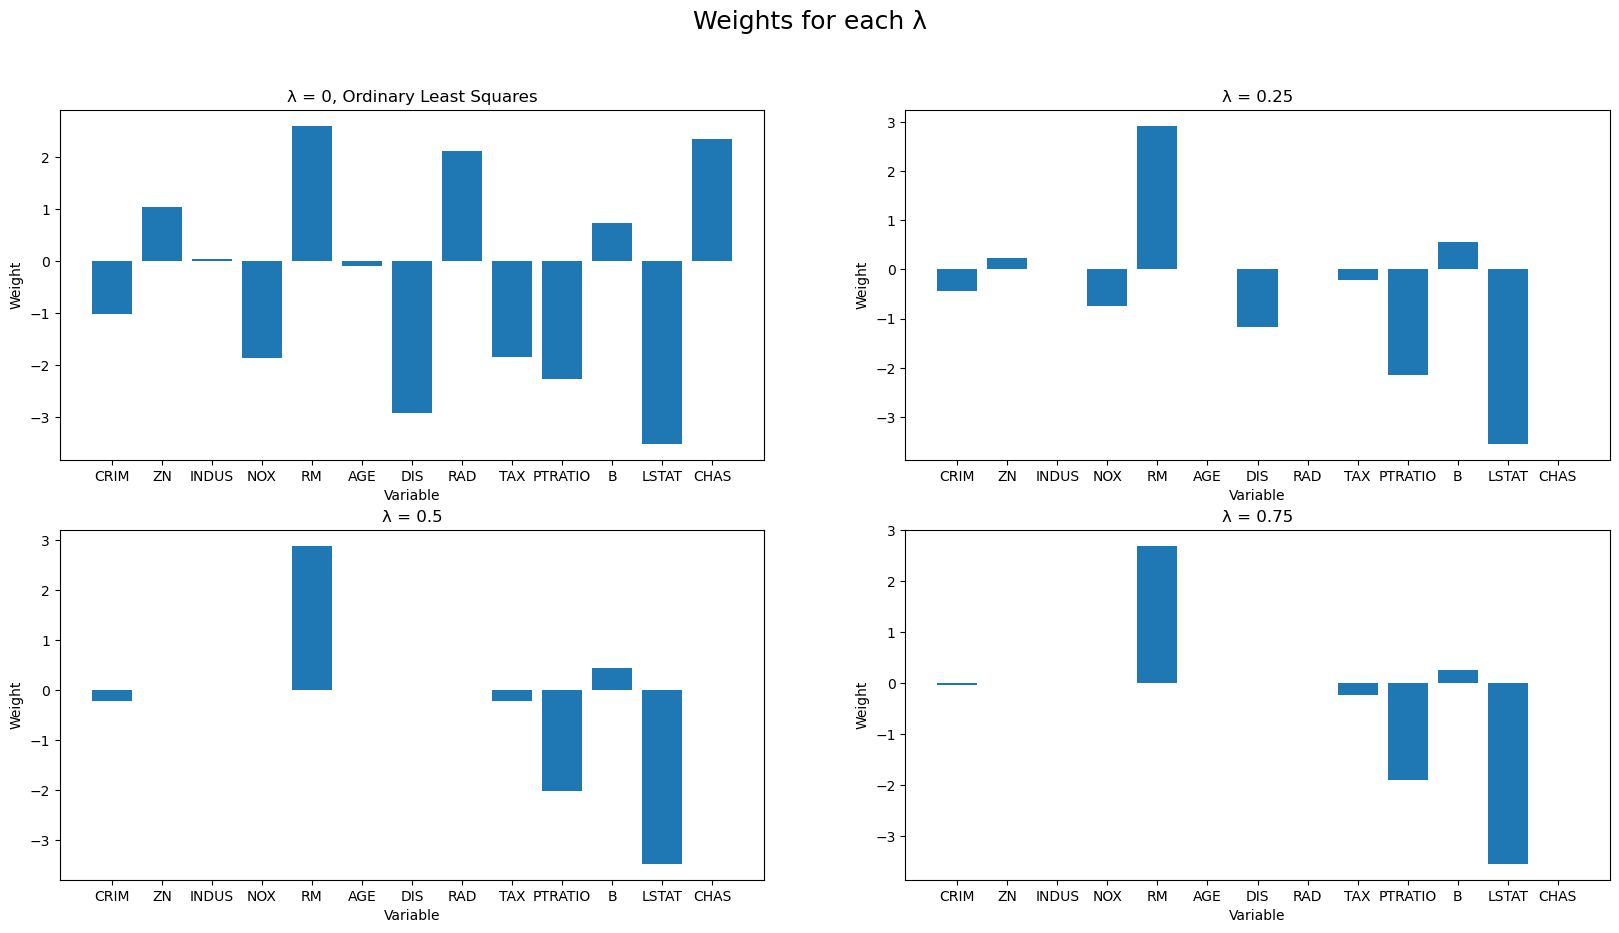

In [14]:
# 4 bar plots of weights for lasso one for l = 0.25, 0.5, 0.75,  1
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

pf.bar_plot(axes[0,0], X_train.columns, weights_lasso[0][1:], 'λ = 0, Ordinary Least Squares', 'Variable', 'Weight')
pf.bar_plot(axes[0,1], X_train.columns, weights_lasso[5][1:], 'λ = 0.25', 'Variable', 'Weight')
pf.bar_plot(axes[1,0], X_train.columns, weights_lasso[10][1:], 'λ = 0.5', 'Variable', 'Weight')
pf.bar_plot(axes[1,1], X_train.columns, weights_lasso[15][1:], 'λ = 0.75', 'Variable', 'Weight')

fig.suptitle('Weights for each λ', fontsize=18)

plt.show()

In the top left plot, we see the weights of the Ordinary Least Squares regression, which are not penalized. Looking at the weights we cannot detect which variables are important and which are not.

As the lambda value increases from left to right, from top to bottom, we see that the weights of the variables that are not important are set to 0, whilst the ones the regression deems as important keep their values.

Looking at the bottom right plot, we can identify 3 variables that are important, RM, PTRATIO and LSTAT. We can also see that the weights of all the variables that are not important are set to 0.
RM is the average number of rooms per dwelling, PTRATIO is the pupil-teacher ratio by town and LSTAT is the percentage of lower status of the population.
We can interpret this as, the more rooms a house has, the higher the price, the higher the pupil-teacher ratio, the lower the price, and the higher the percentage of lower status of the population, the lower the price.

### Ridge Regression
Ridge Regression is similar to Lasso Regression but differs in the penalty term. The optimization function for Ridge Regression is given by:
$$\min_{\beta} \left\{ \frac{1}{2N} \sum_{i=1}^{N} (y_i - X_i\beta)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right\}$$
In this formulation, $\beta$, $y_i$, $X_i$, $N$, and $p$ have the same meanings as in Lasso Regression. The key difference is the penalty term $\lambda \sum_{j=1}^{p} \beta_j^2$, which penalizes the square of the coefficients, encouraging smaller coefficients but not necessarily zeroing them out as in Lasso.

In [15]:
# run the ridge regression
lambdas_ridge = np.arange(0, 25, 0.5)

# apply ridge regression for each λ
weights_ridge = [cf.linear_regression(X_train, y_train, cf.gradient_ridge, alpha=l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]

mse_ridge, r2_ridge = cf.fit_calculate(X_test_bias, y_test, weights_ridge)

100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


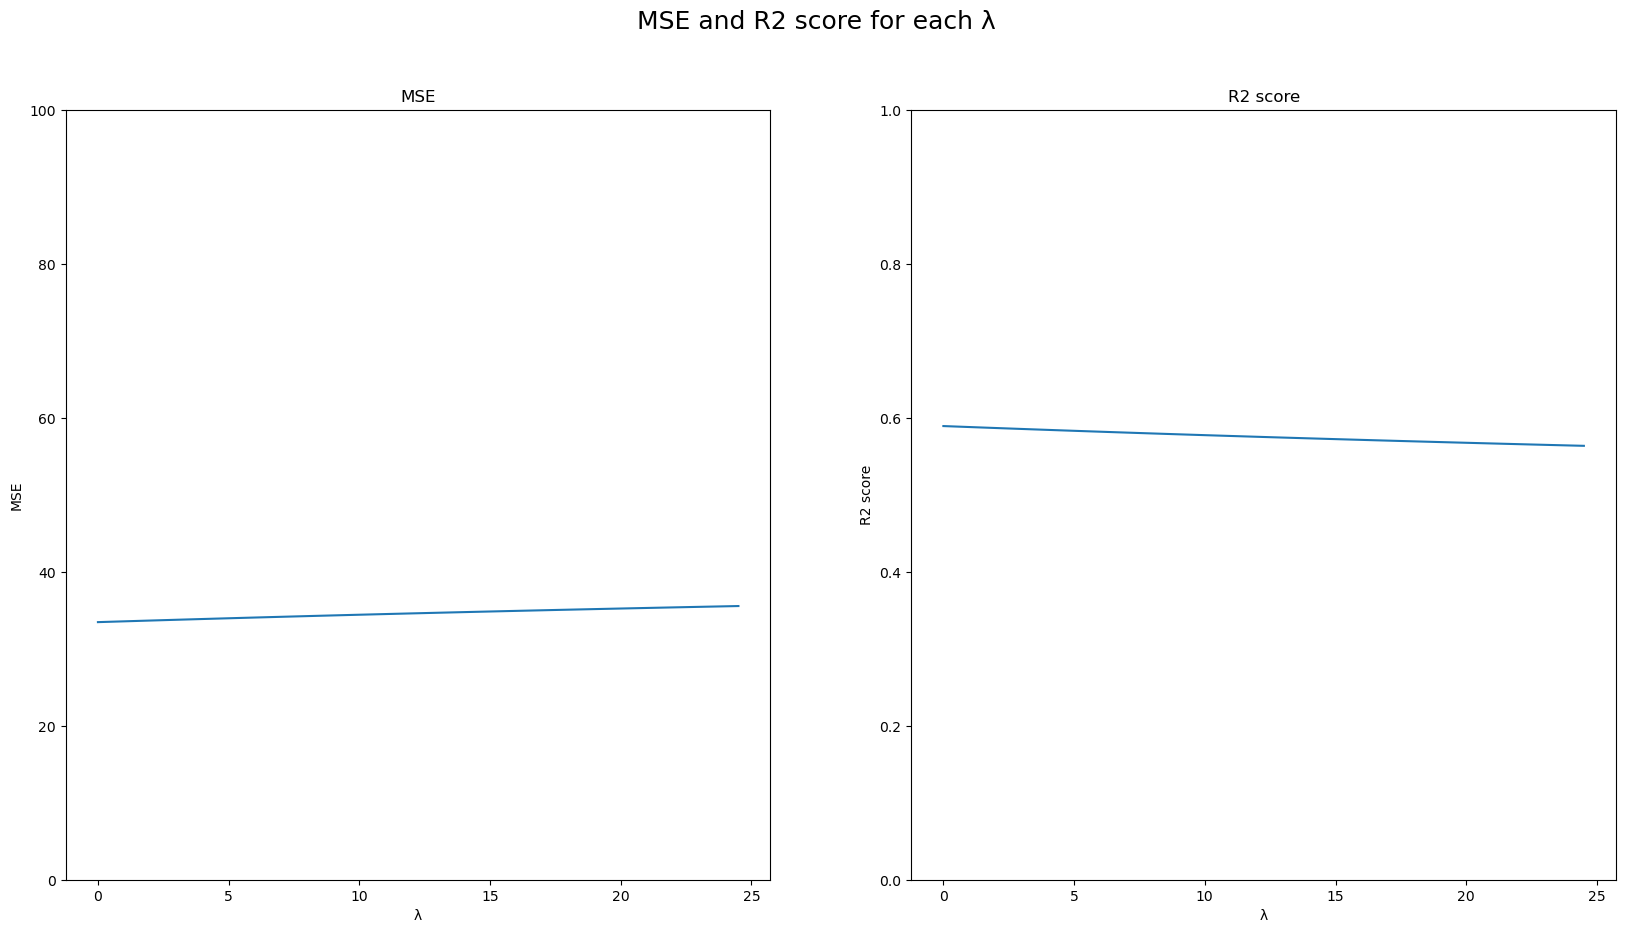

In [16]:
# plot the MSE and R2 score for each λ
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

pf.line_plot(axes[0], lambdas_ridge, mse_ridge, 'MSE', 'λ', 'MSE', y_lim=[0, 100])
pf.line_plot(axes[1], lambdas_ridge, r2_ridge, 'R2 score', 'λ', 'R2 score', y_lim=[0, 1]) 

fig.suptitle('MSE and R2 score for each λ', fontsize=18)

plt.show()

We see that Ridge Regression in our case, does not perform better than the Ordinary Least Squares.
The values seem to be invariant to the value of λ.

We can conclude that Lasso Regression is the best method for our dataset, if we are looking to extract the most important variables.

## Handling Missing Data and Data Imputation
In real-world datasets, missing data is a common occurrence and can significantly impact the performance of machine learning models. In this part of the analysis, we systematically introduce missing values into the Boston Housing dataset at different intervals to study their effect on regression models.

We then employ the nuclear norm method for data imputation. The nuclear norm approach is a sophisticated technique for imputing missing data, which we hope will improve the performance of our regression models on the incomplete dataset.

The comparison of model performances before and after imputation will provide valuable insights into the effectiveness of the nuclear norm method and the robustness of regression models to missing data.

To simulate a scenario where data might be missing from our dataset, we have created a function to remove values incrementally. This function introduces additional missing values at random positions within the data, allowing us to examine the impact of sparsity on our model's performance. By incrementally increasing the missingness from 25% to 75%, we can observe the robustness of our regression models under progressively challenging conditions.

In [17]:
# split the dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(normalized_indep_vars, dep_var, test_size=0.2, random_state=1)

X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]

In [18]:
# Creating the datasets with incremental sparsity
dataset_75_incremental_original = cf.incrementally_introduce_missing_values(X_train, 0.25)
dataset_50_incremental_original = cf.incrementally_introduce_missing_values(dataset_75_incremental_original, 0.25)
dataset_25_incremental_original = cf.incrementally_introduce_missing_values(dataset_50_incremental_original, 0.25)

# Calculating and printing the sparsity of each dataset
sparsity_75_incremental = np.isnan(dataset_75_incremental_original).sum().sum() / dataset_75_incremental_original.size
sparsity_50_incremental = np.isnan(dataset_50_incremental_original).sum().sum() / dataset_50_incremental_original.size
sparsity_25_incremental = np.isnan(dataset_25_incremental_original).sum().sum() / dataset_25_incremental_original.size

(sparsity_75_incremental, sparsity_50_incremental, sparsity_25_incremental)

(0.25, 0.5, 0.75)

A visual inspection of missing data can provide intuitive insight into the challenge ahead for any imputation method. Here, we visualize the sparsity pattern of our datasets with 25%, 50%, and 75% missing values using heatmaps. The white spaces represent the missing values, giving us a quick sense of how much information is absent and how it's distributed across the dataset.


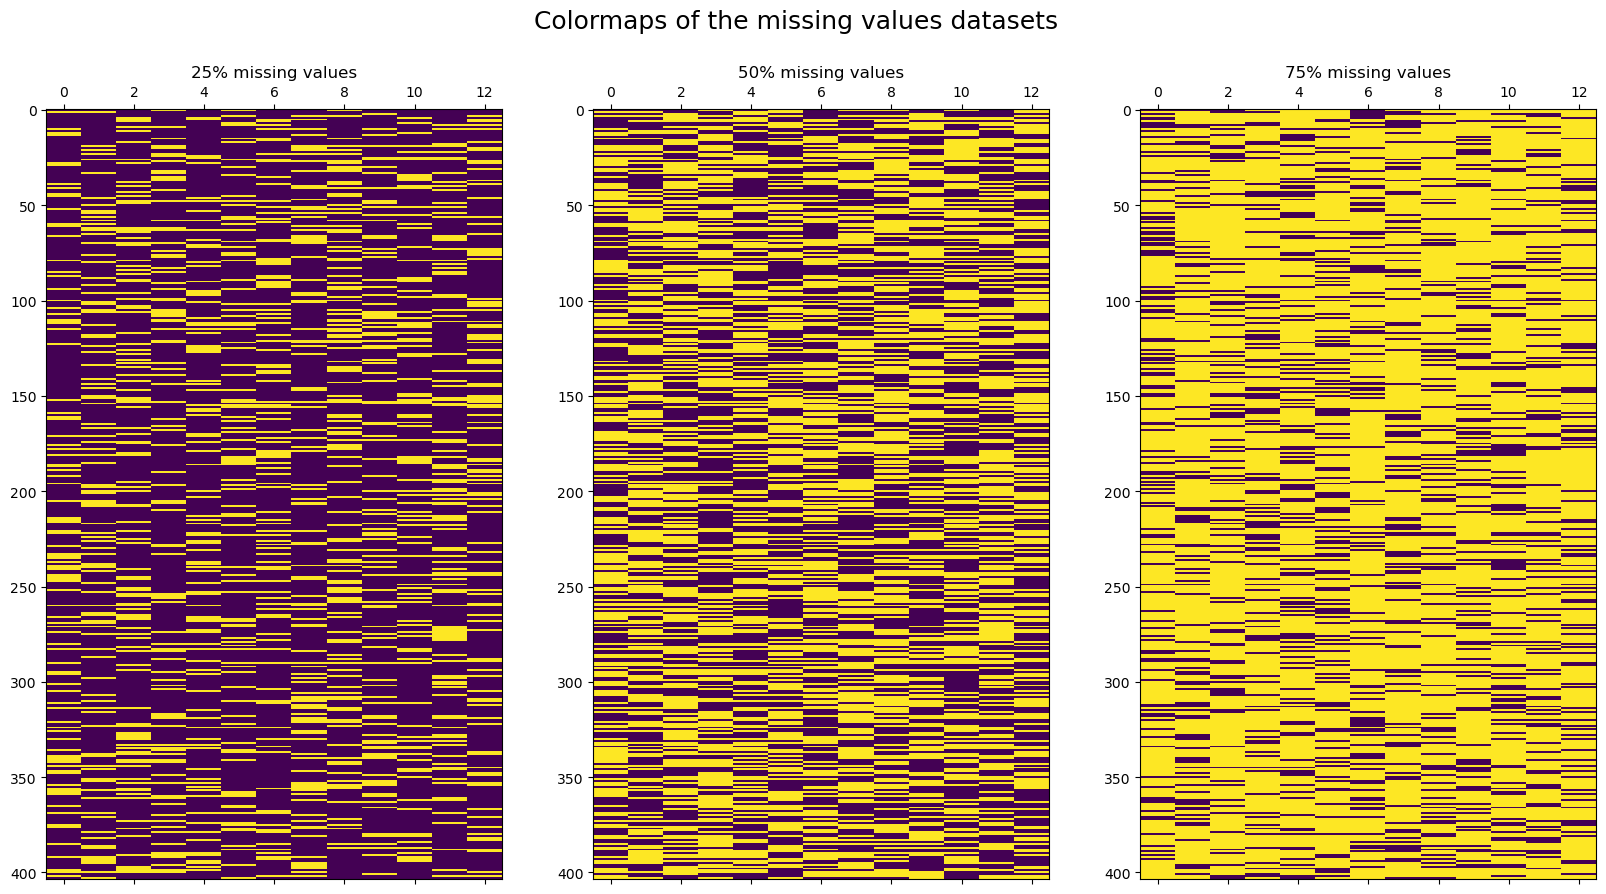

In [19]:
# heatmap of the 3 matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

axes[0].matshow(dataset_75_incremental_original.isnull(), interpolation='none', aspect='auto')
axes[0].set_title('25% missing values')

axes[1].matshow(dataset_50_incremental_original.isnull(), interpolation='none', aspect='auto')
axes[1].set_title('50% missing values')

axes[2].matshow(dataset_25_incremental_original.isnull(), interpolation='none', aspect='auto')
axes[2].set_title('75% missing values')

fig.suptitle('Colormaps of the missing values datasets', fontsize=18)

plt.show()

Confronted with missing data, a preliminary approach is to impute these gaps with a placeholder value, such as zero. This technique, while naive, allows us to proceed with regression methods that require complete data. However, this is only a stopgap measure, as replacing missing values with zeros can lead to biased estimates and poor model performance, particularly when the missingness is not random.


In [20]:
# replace nan values with 0
dataset_75_incremental = dataset_75_incremental_original.fillna(0)
dataset_50_incremental = dataset_50_incremental_original.fillna(0)
dataset_25_incremental = dataset_25_incremental_original.fillna(0)

Upon imputing missing values, we proceed to fit regression models to our now 'complete' datasets. Unconstrained least squares, Lasso, and Ridge regression are employed, each with its approach to handling overfitting and underfitting. Lasso and Ridge are particularly useful when dealing with features not significantly contributing to the predictive power, which might be the case in datasets with artificially introduced zeros.


In [21]:
# run unconstrained, lasso and ridge regression for each dataset
weights_ols_100_incremental = cf.linear_regression(X_train, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)
weights_ols_75_incremental = cf.linear_regression(dataset_75_incremental, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)
weights_ols_50_incremental = cf.linear_regression(dataset_50_incremental, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)
weights_ols_25_incremental = cf.linear_regression(dataset_25_incremental, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)

# run lasso for range of lambdas
lambdas_lasso_missing = np.arange(0, 8, 0.1)
weights_lasso_100_incremental = [cf.linear_regression(X_train, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas_lasso_missing)]
weights_lasso_75_incremental = [cf.linear_regression(dataset_75_incremental, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas_lasso_missing)]
weights_lasso_50_incremental = [cf.linear_regression(dataset_50_incremental, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas_lasso_missing)]
weights_lasso_25_incremental = [cf.linear_regression(dataset_25_incremental, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas_lasso_missing)]

# run ridge for range of lambdas
lambdas_ridge = np.arange(0, 160, 1)
weights_ridge_100_incremental = [cf.linear_regression(X_train, y_train, cf.gradient_ridge, l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]
weights_ridge_75_incremental = [cf.linear_regression(dataset_75_incremental, y_train, cf.gradient_ridge, l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]
weights_ridge_50_incremental = [cf.linear_regression(dataset_50_incremental, y_train, cf.gradient_ridge, l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]
weights_ridge_25_incremental = [cf.linear_regression(dataset_25_incremental, y_train, cf.gradient_ridge, l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]

100%|██████████| 160/160 [00:19<00:00,  8.35it/s]


To evaluate the impact of missing data and our imputation strategy, we plot the Mean Squared Error (MSE) across different models and levels of data sparsity. This visualization aids in comparing the models quantitatively, highlighting the trade-offs between model complexity (regularization in Lasso and Ridge) and error. The MSE serves as a benchmark to assess the cost of inaccuracies in our predictions.


In [22]:
# calculate mse and r2 score for each model
mse_ols_100_incremental, r2_ols_100_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ols_100_incremental)
mse_ols_75_incremental, r2_ols_75_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ols_75_incremental)
mse_ols_50_incremental, r2_ols_50_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ols_50_incremental)
mse_ols_25_incremental, r2_ols_25_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ols_25_incremental)

mse_lasso_100_incremental, r2_lasso_100_incremental = cf.fit_calculate(X_test_bias, y_test, weights_lasso_100_incremental)
mse_lasso_75_incremental, r2_lasso_75_incremental = cf.fit_calculate(X_test_bias, y_test, weights_lasso_75_incremental)
mse_lasso_50_incremental, r2_lasso_50_incremental = cf.fit_calculate(X_test_bias, y_test, weights_lasso_50_incremental)
mse_lasso_25_incremental, r2_lasso_25_incremental = cf.fit_calculate(X_test_bias, y_test, weights_lasso_25_incremental)

mse_ridge_100_incremental, r2_ridge_100_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ridge_100_incremental)
mse_ridge_75_incremental, r2_ridge_75_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ridge_75_incremental)
mse_ridge_50_incremental, r2_ridge_50_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ridge_50_incremental)
mse_ridge_25_incremental, r2_ridge_25_incremental = cf.fit_calculate(X_test_bias, y_test, weights_ridge_25_incremental)

Understanding the influence of each predictor on the outcome is crucial. Here, we plot the evolution of feature weights in Lasso regression as the regularization parameter λ changes. These plots elucidate the feature selection aspect of Lasso — as λ increases, less significant features are penalized more heavily, their corresponding weights shrinking towards zero, which can help in identifying the most informative predictors in the presence of missing data.


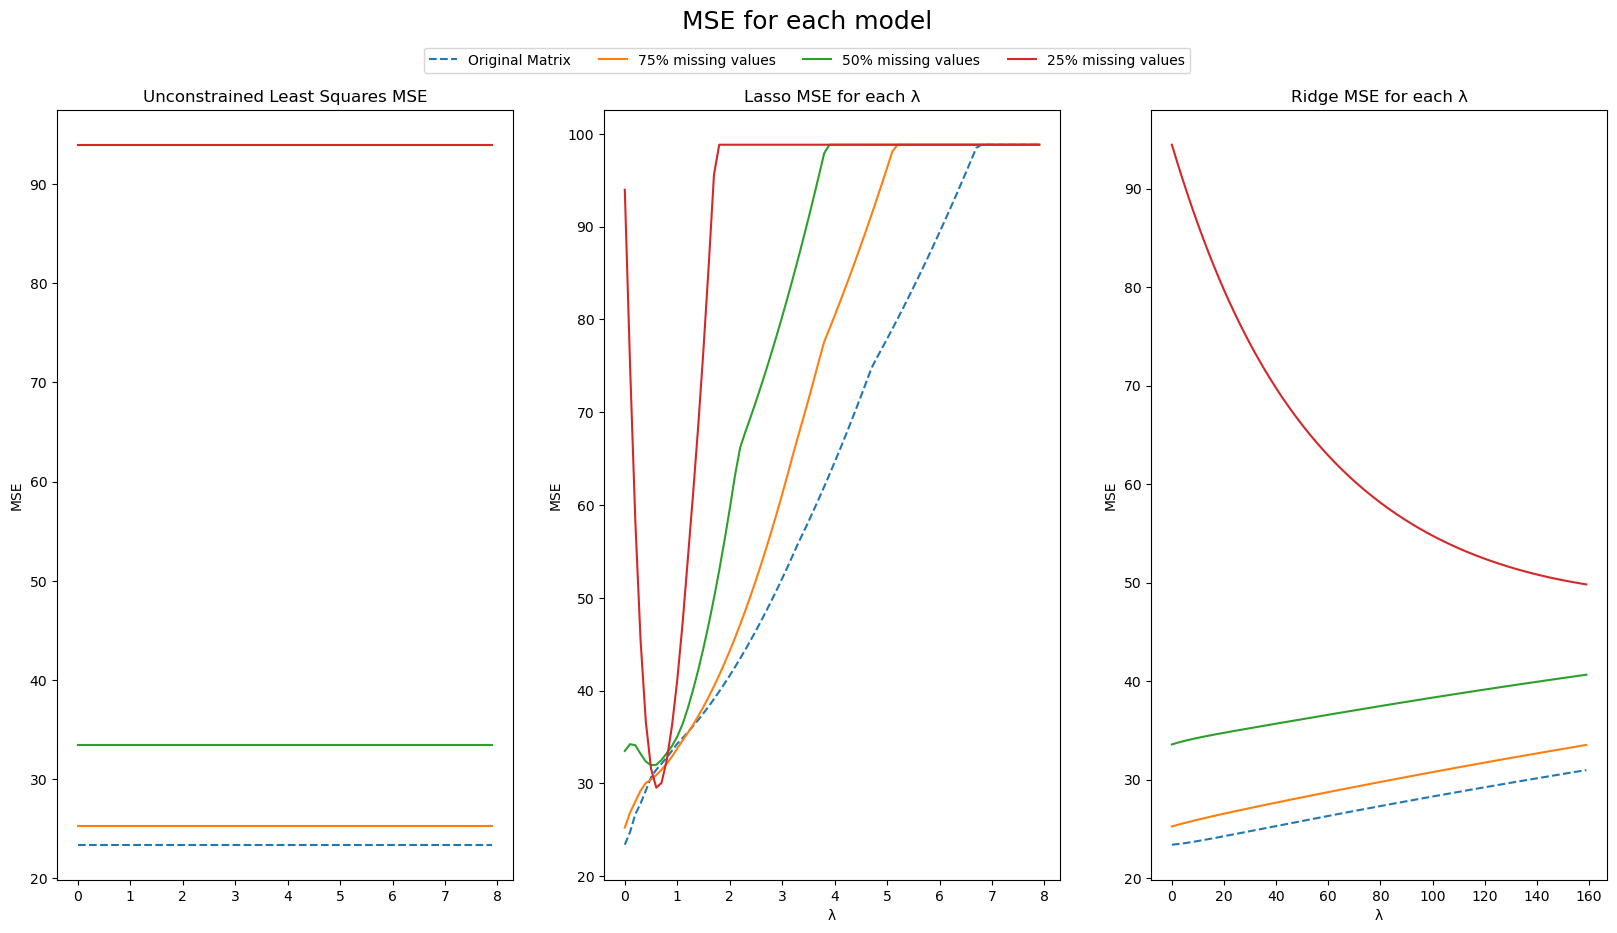

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

axes[0].plot(lambdas_lasso_missing, mse_ols_100_incremental*np.ones(len(lambdas_lasso_missing)), '--')
axes[0].plot(lambdas_lasso_missing, mse_ols_75_incremental*np.ones(len(lambdas_lasso_missing)))
axes[0].plot(lambdas_lasso_missing, mse_ols_50_incremental*np.ones(len(lambdas_lasso_missing)))
axes[0].plot(lambdas_lasso_missing, mse_ols_25_incremental*np.ones(len(lambdas_lasso_missing)))
axes[0].set_title('Unconstrained Least Squares MSE')
axes[0].set_ylabel('MSE')


axes[1].plot(lambdas_lasso_missing, mse_lasso_100_incremental, '--')
axes[1].plot(lambdas_lasso_missing, mse_lasso_75_incremental)
axes[1].plot(lambdas_lasso_missing, mse_lasso_50_incremental)
axes[1].plot(lambdas_lasso_missing, mse_lasso_25_incremental)
axes[1].set_title('Lasso MSE for each λ')
axes[1].set_xlabel('λ')
axes[1].set_ylabel('MSE')

axes[2].plot(lambdas_ridge, mse_ridge_100_incremental, '--')
axes[2].plot(lambdas_ridge, mse_ridge_75_incremental)
axes[2].plot(lambdas_ridge, mse_ridge_50_incremental)
axes[2].plot(lambdas_ridge, mse_ridge_25_incremental)
axes[2].set_title('Ridge MSE for each λ')
axes[2].set_xlabel('λ')
axes[2].set_ylabel('MSE')

fig.suptitle('MSE for each model', fontsize=18)

fig.legend(['Original Matrix', '75% missing values', '50% missing values', '25% missing values'],
           loc='lower center', bbox_to_anchor=(0.5, 0.91), ncol=4)

plt.show()

We observe that as the sparsity of the dataset increases, the Unconstrained Least Squares regression performs significantly worse, while the Lasso and Ridge regression perform better.
We also see that, as the number of values decrease, the Lasso Regression gets more and more sensitive to the value of λ, whilst also still being able to identify the most important variables, and keep the MSE relatively low.
On the Ridge regression plot, we see that for the 100% 75% and 50% missing values datasets, the MSE is the same or worse than the Unconstrained Least Squares regression, whilst for the 25% missing values dataset, for bigger lambda values, the algorithm performs significantly better but still worse than Lasso.

Introducing missing values on the 'key' variables, which Lasso heavily favors, would in theory result in worse performance. But as it stands, a uniform sparseness seems to be combated by this algorithm more effectively than the other two. 

Let's plot the weights of the Lasso Regression for the different datasets, to see how they change as the level of sparsity increases.

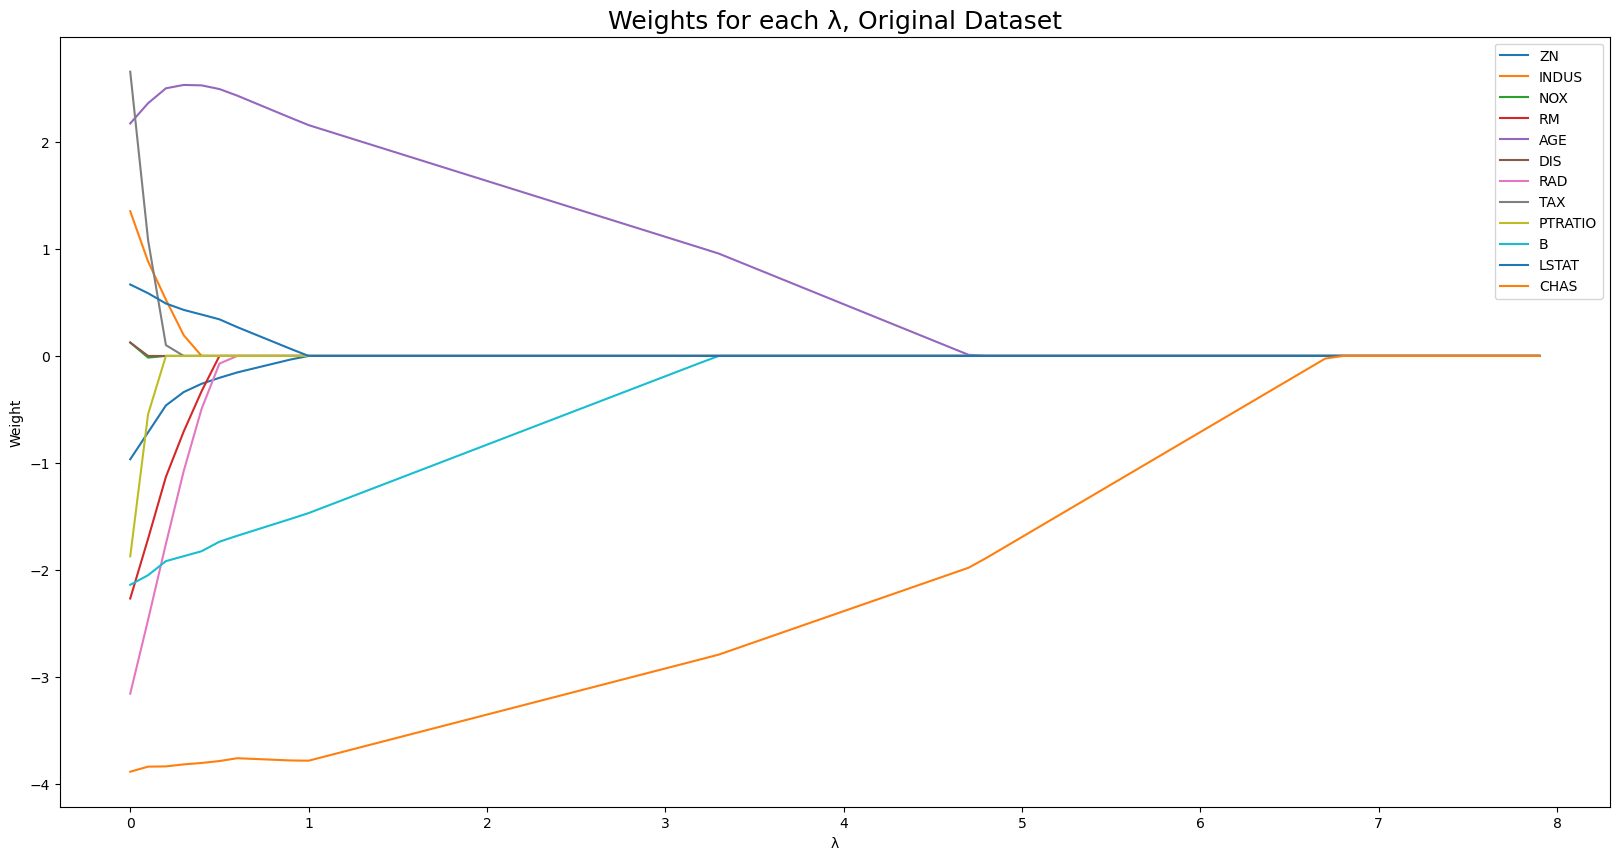

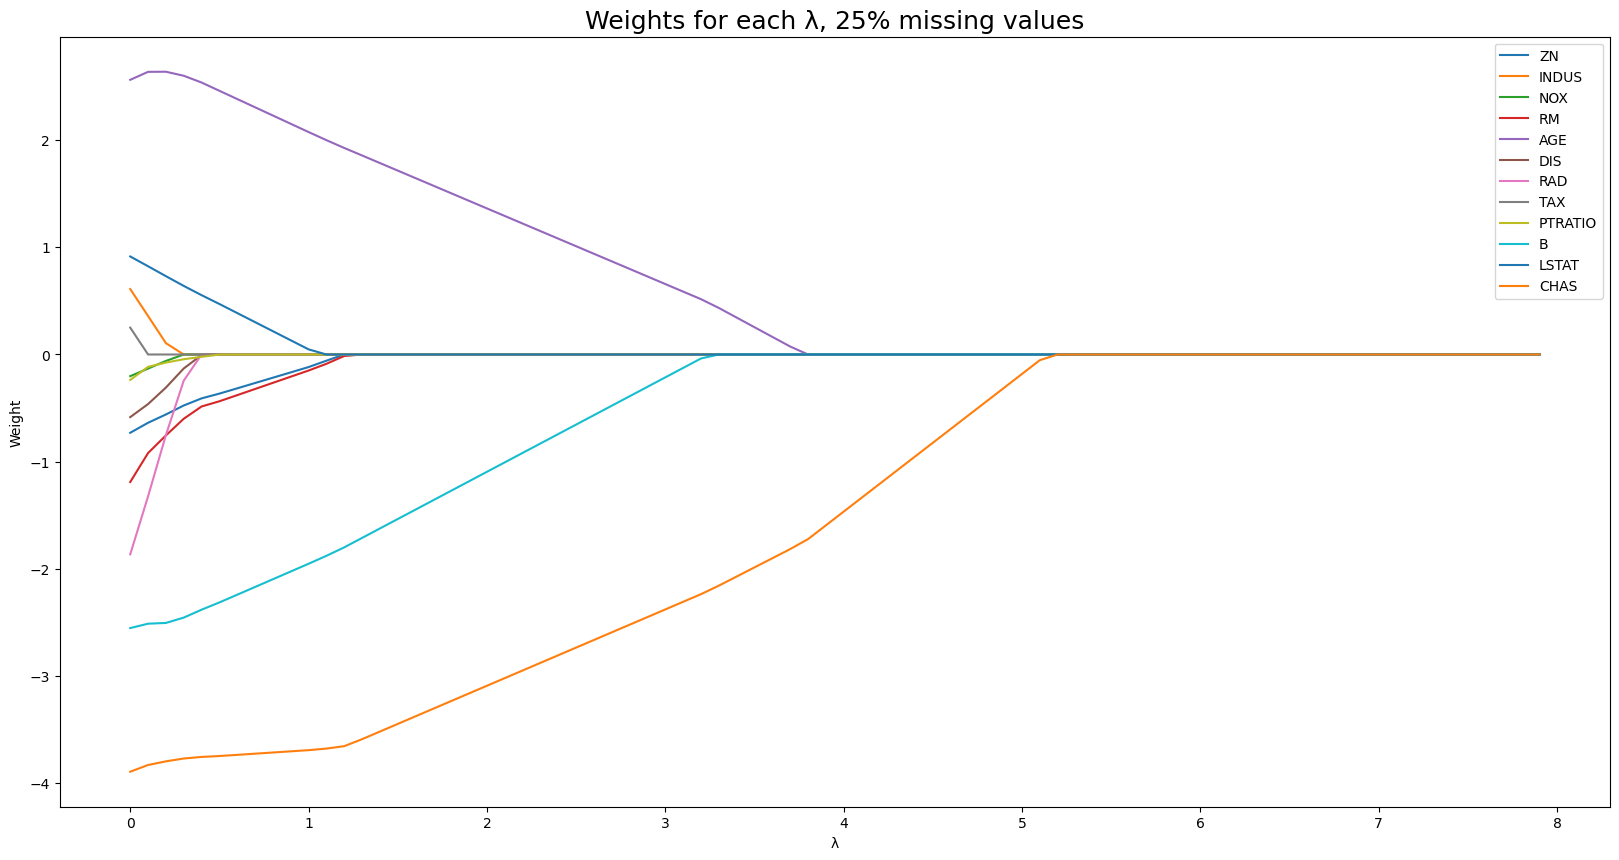

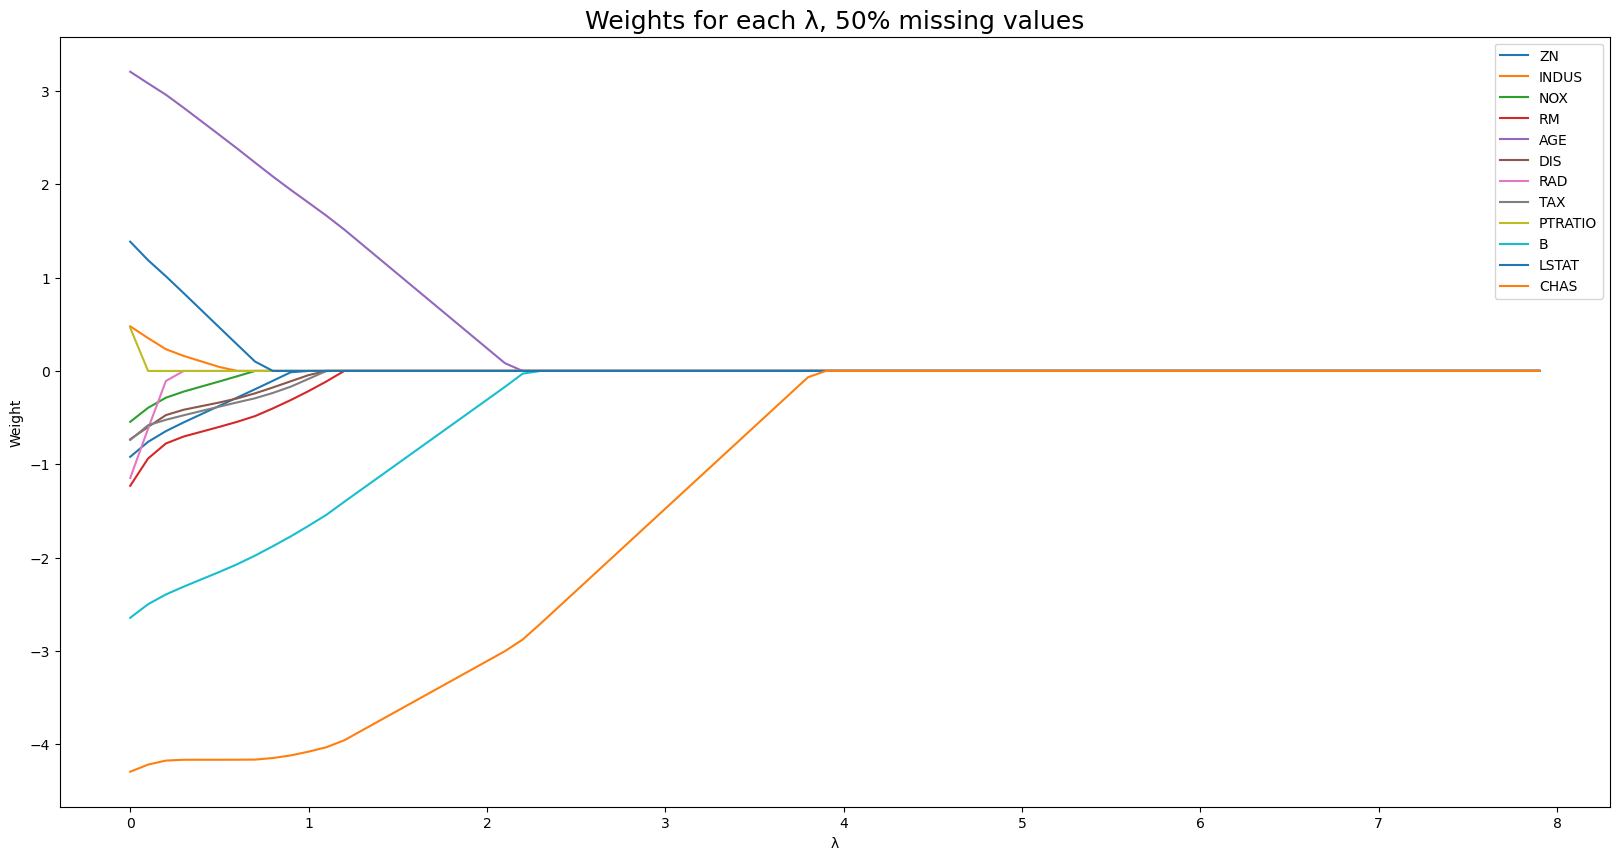

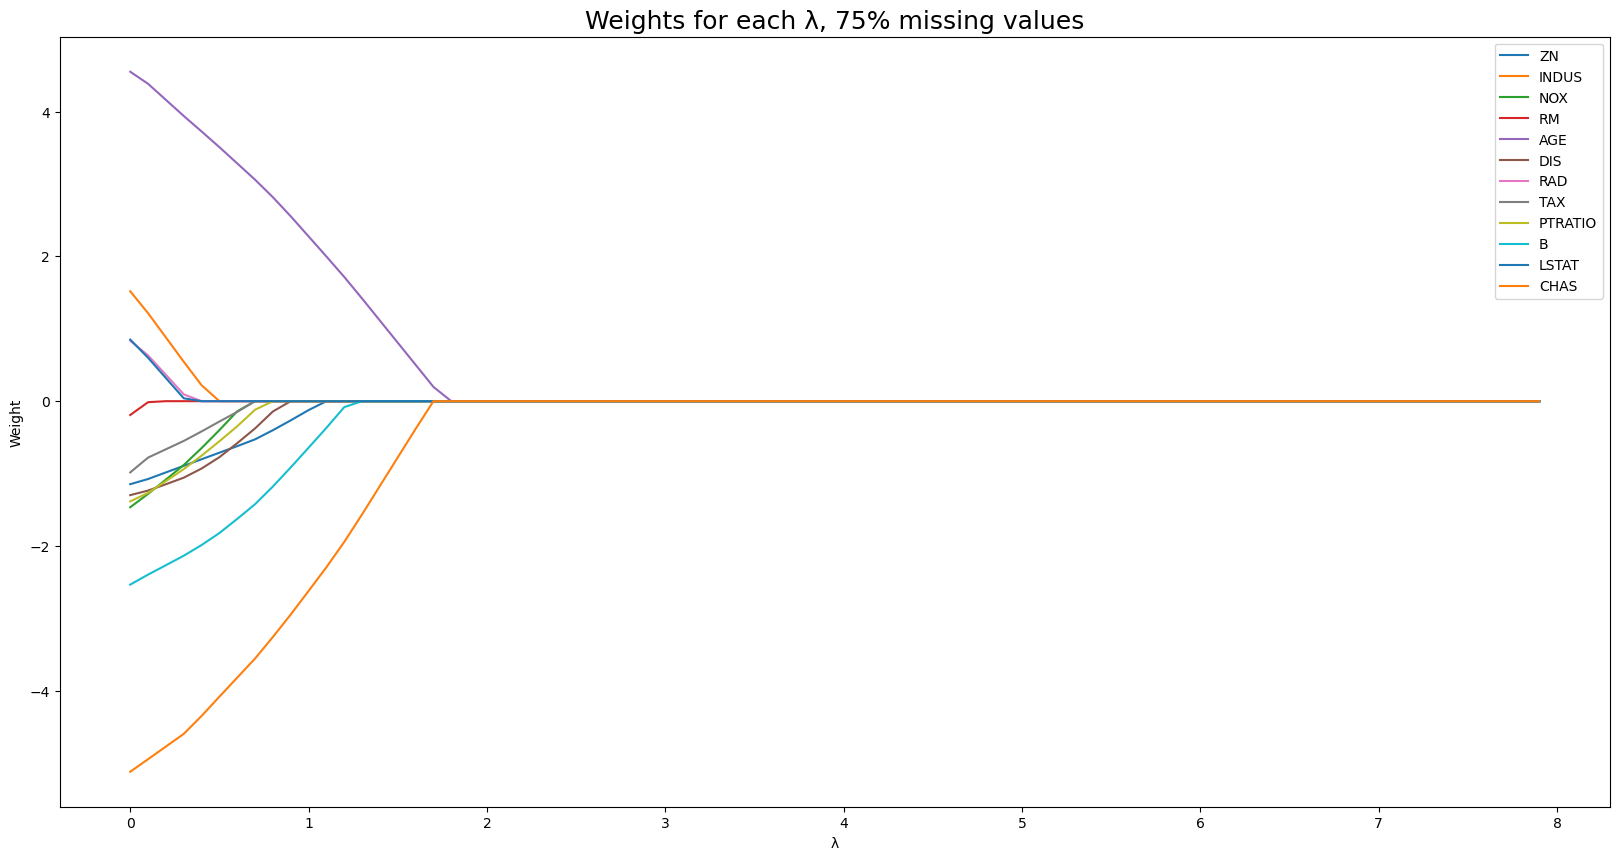

In [24]:
pf.lasso_weights_plot(weights_lasso_100_incremental, lambdas_lasso_missing, X_train.columns, 'Weights for each λ, Original Dataset', 'λ', 'Weight')
pf.lasso_weights_plot(weights_lasso_75_incremental, lambdas_lasso_missing, X_train.columns, 'Weights for each λ, 25% missing values', 'λ', 'Weight')
pf.lasso_weights_plot(weights_lasso_50_incremental, lambdas_lasso_missing, X_train.columns, 'Weights for each λ, 50% missing values', 'λ', 'Weight')
pf.lasso_weights_plot(weights_lasso_25_incremental, lambdas_lasso_missing, X_train.columns, 'Weights for each λ, 75% missing values', 'λ', 'Weight')

We see that for increasing sparseness, the cutoff points of all the variables, is getting smaller and smaller, meaning that the algorithm is getting more and more sensitive to the value of λ.
We also should note that for the 100% 75% and 50% missing values datasets, the algorithm selects the same variables as lambda increases, whilst for the 25% missing values dataset, the last 2 variables that are not set to zero, thus deemed most important, are not the same as the previous sparsity levels.

## Handling Missing Data and Data Imputation

In this section, we tackle the problem of missing values with a more systematic approach. We employ the nuclear norm method for data imputation, which is a sophisticated technique for imputing missing data. The comparison of model performances before and after imputation will provide valuable insights into the effectiveness of the nuclear norm method and the robustness of regression models to missing data.

### Nuclear Norm for Data Imputation
The nuclear norm method for data imputation is a sophisticated technique that seeks to minimize the sum of the singular values of a matrix. It is particularly useful for imputing missing data in a matrix. The optimization problem can be formulated as:
$$\min_{X} \|X - M\|_F^2 + \lambda \|X\|_*$$
Here, $X$ is the matrix with imputed values, $M$ is the original matrix with missing values, $\|\cdot\|_F$ denotes the Frobenius norm, $\|\cdot\|_*$ denotes the nuclear norm, and $\lambda$ is a regularization parameter. This method balances fitting the observed data and keeping the matrix 'low-rank', which helps in capturing the underlying structure in the data.

In [25]:
# calculate the mse of the reconstruction
dataset_75_imputed, mse_75 = cf.impute(dataset_75_incremental_original, X_train, lambda_val=3.5, tolerance=1e-6, max_iterations=100)
print(f"MSE of reconstruction of 25% missing values: {mse_75}")

dataset_50_imputed, mse_50 = cf.impute(dataset_50_incremental_original, X_train, lambda_val=3.5, tolerance=1e-6, max_iterations=100)
print(f"MSE of reconstruction of 50% missing values: {mse_50}")

dataset_25_imputed, mse_25 = cf.impute(dataset_25_incremental_original, X_train, lambda_val=3.5, tolerance=1e-6, max_iterations=100)
print(f"MSE of reconstruction of 75% missing values: {mse_25}")

MSE of reconstruction of 25% missing values: 0.11515384619102106
MSE of reconstruction of 50% missing values: 0.26212533030365504
MSE of reconstruction of 75% missing values: 0.4822077224720684


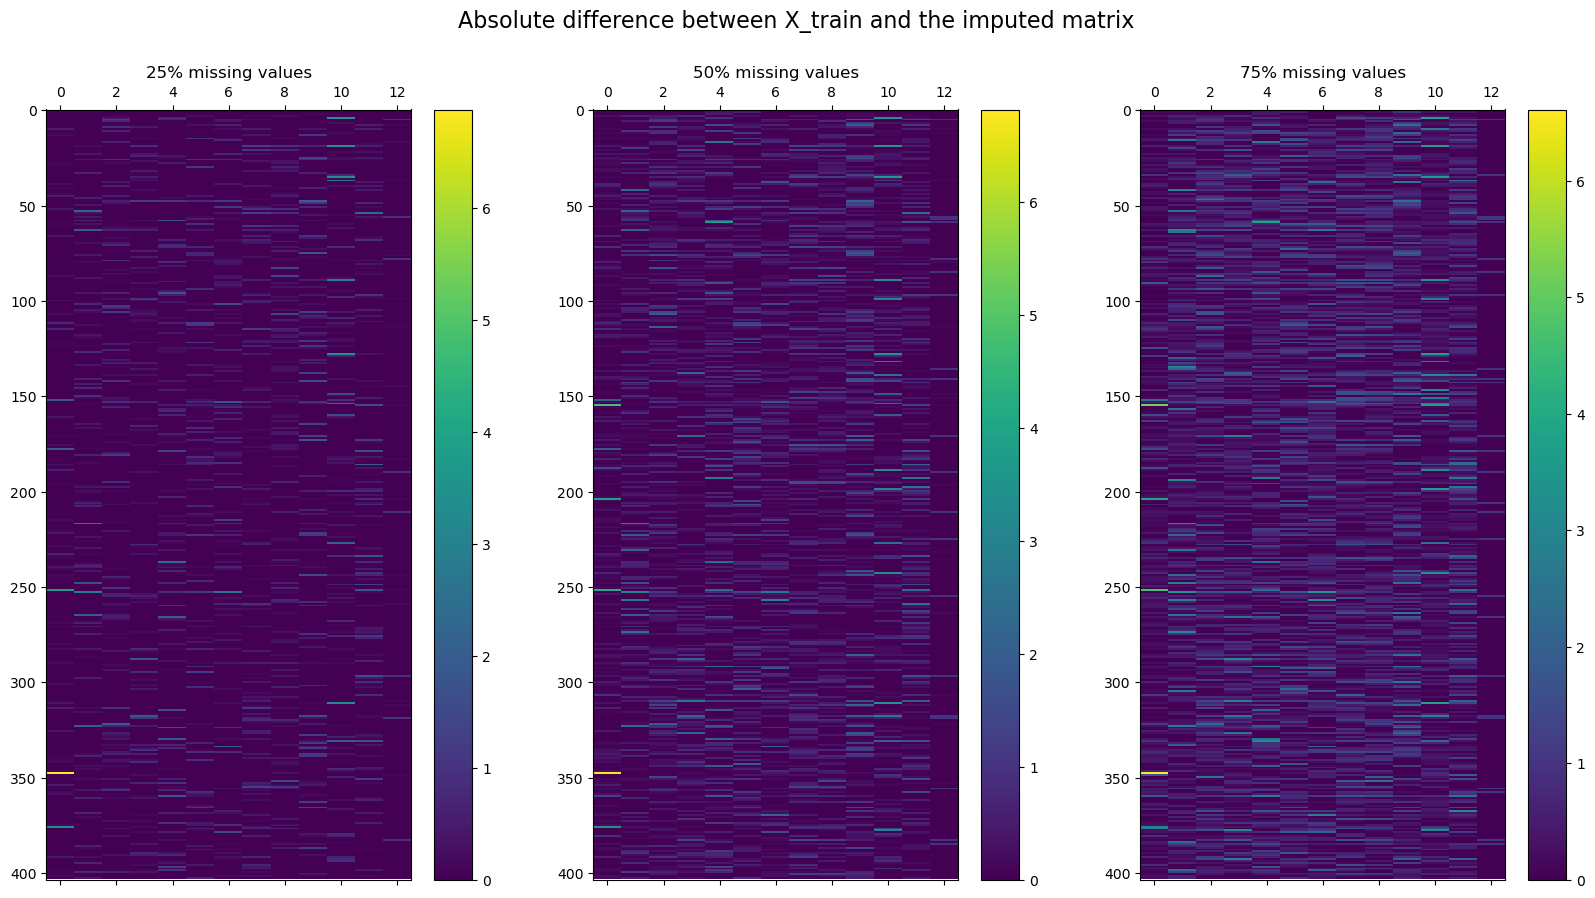

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

# plot the absolute difference between X_train and the imputed matrix
axes[0].matshow(np.abs(X_train - dataset_75_imputed), interpolation='none', aspect='auto')
axes[0].set_title('25% missing values')
cbar = fig.colorbar(axes[0].imshow(np.abs(X_train - dataset_75_imputed), interpolation='none', aspect='auto'), ax=axes[0])

axes[1].matshow(np.abs(X_train - dataset_50_imputed), interpolation='none', aspect='auto')
axes[1].set_title('50% missing values')
cbar = fig.colorbar(axes[1].imshow(np.abs(X_train - dataset_50_imputed), interpolation='none', aspect='auto'), ax=axes[1])

axes[2].matshow(np.abs(X_train - dataset_25_imputed), interpolation='none', aspect='auto')
axes[2].set_title('75% missing values')
cbar = fig.colorbar(axes[2].imshow(np.abs(X_train - dataset_25_imputed), interpolation='none', aspect='auto'), ax=axes[2])

# add a figure title
fig.suptitle('Absolute difference between X_train and the imputed matrix', fontsize=16)

plt.show()

In [27]:
# run unconstrained, lasso and ridge regression for each dataset
weights_ols_75_imputed = cf.linear_regression(dataset_75_imputed, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)
weights_ols_50_imputed = cf.linear_regression(dataset_50_imputed, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)
weights_ols_25_imputed = cf.linear_regression(dataset_25_imputed, y_train, cf.gradient_ols, learning_rate=0.0001, epochs=5000)

# run lasso for range of lambdas
lambdas_lasso_imputed = np.arange(0, 8, 0.1)
weights_lasso_75_imputed = [cf.linear_regression(dataset_75_imputed, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas_lasso_imputed)]
weights_lasso_50_imputed = [cf.linear_regression(dataset_50_imputed, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas_lasso_imputed)]
weights_lasso_25_imputed = [cf.linear_regression(dataset_25_imputed, y_train, cf.gradient_lasso, l, epochs=100, show_progress=False) for l in tqdm(lambdas_lasso_imputed)]

# run ridge for range of lambdas
lambdas_ridge = np.arange(0, 160, 1)
weights_ridge_75_imputed = [cf.linear_regression(dataset_75_imputed, y_train, cf.gradient_ridge, l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]
weights_ridge_50_imputed = [cf.linear_regression(dataset_50_imputed, y_train, cf.gradient_ridge, l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]
weights_ridge_25_imputed = [cf.linear_regression(dataset_25_imputed, y_train, cf.gradient_ridge, l, learning_rate=0.0001, epochs=1000, show_progress=False) for l in tqdm(lambdas_ridge)]

100%|██████████| 160/160 [00:18<00:00,  8.42it/s]


In [28]:
# calculate mse and r2 score for each model
mse_ols_75_imputed, r2_ols_75_imputed = cf.fit_calculate(X_test_bias, y_test, weights_ols_75_imputed)
mse_ols_50_imputed, r2_ols_50_imputed = cf.fit_calculate(X_test_bias, y_test, weights_ols_50_imputed)
mse_ols_25_imputed, r2_ols_25_imputed = cf.fit_calculate(X_test_bias, y_test, weights_ols_25_imputed)

mse_lasso_75_imputed, r2_lasso_75_imputed = cf.fit_calculate(X_test_bias, y_test, weights_lasso_75_imputed)
mse_lasso_50_imputed, r2_lasso_50_imputed = cf.fit_calculate(X_test_bias, y_test, weights_lasso_50_imputed)
mse_lasso_25_imputed, r2_lasso_25_imputed = cf.fit_calculate(X_test_bias, y_test, weights_lasso_25_imputed)

mse_ridge_75_imputed, r2_ridge_75_imputed = cf.fit_calculate(X_test_bias, y_test, weights_ridge_75_imputed)
mse_ridge_50_imputed, r2_ridge_50_imputed = cf.fit_calculate(X_test_bias, y_test, weights_ridge_50_imputed)
mse_ridge_25_imputed, r2_ridge_25_imputed = cf.fit_calculate(X_test_bias, y_test, weights_ridge_25_imputed)

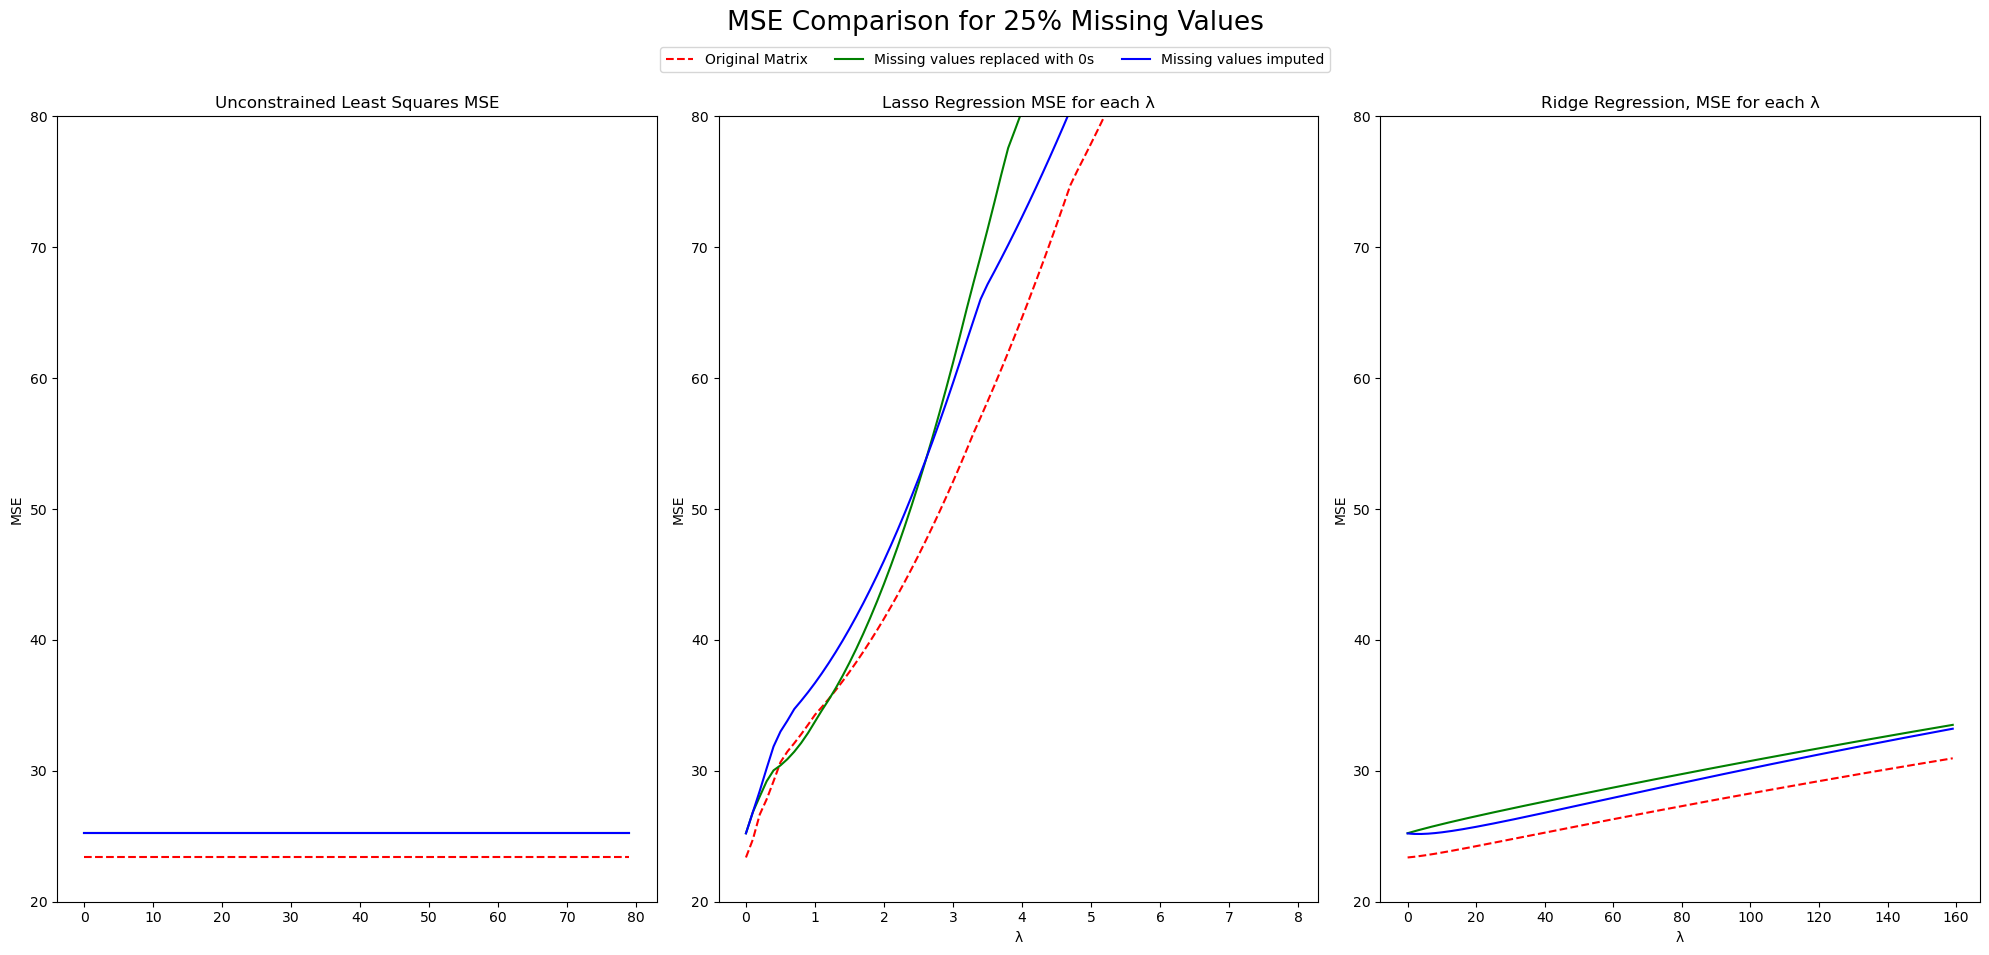

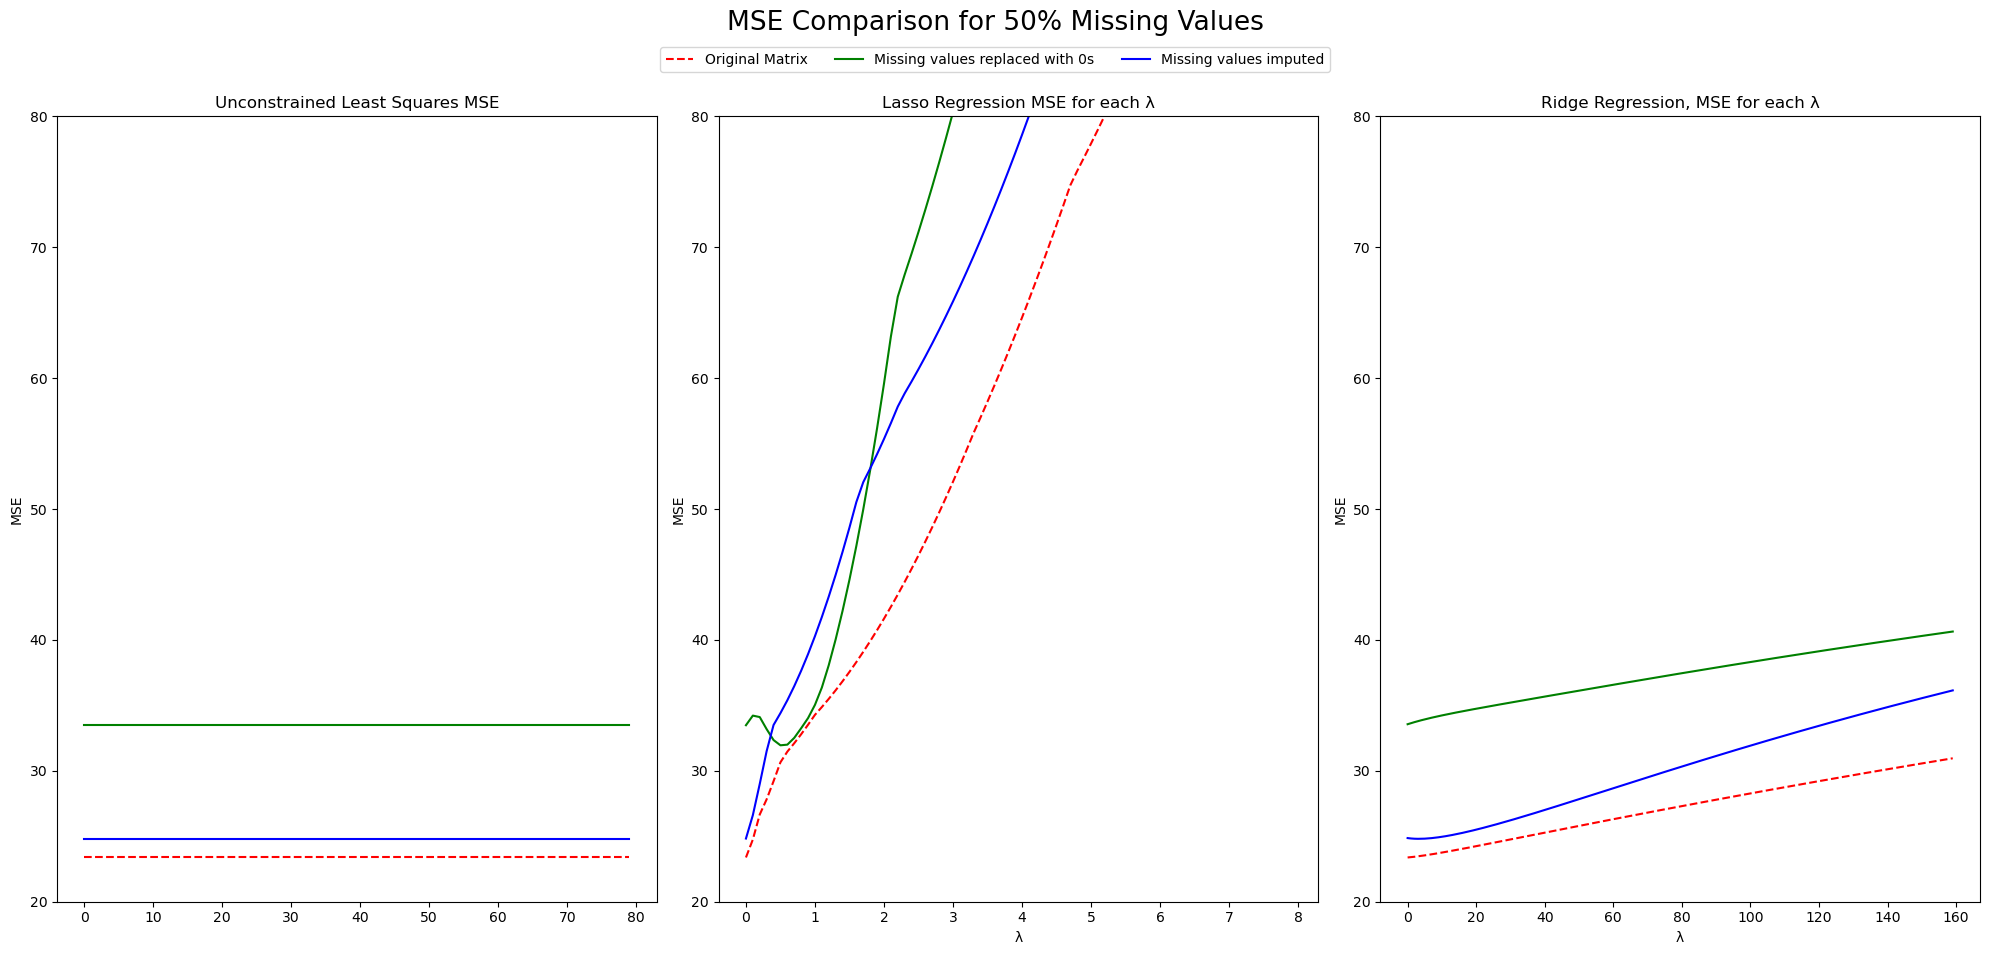

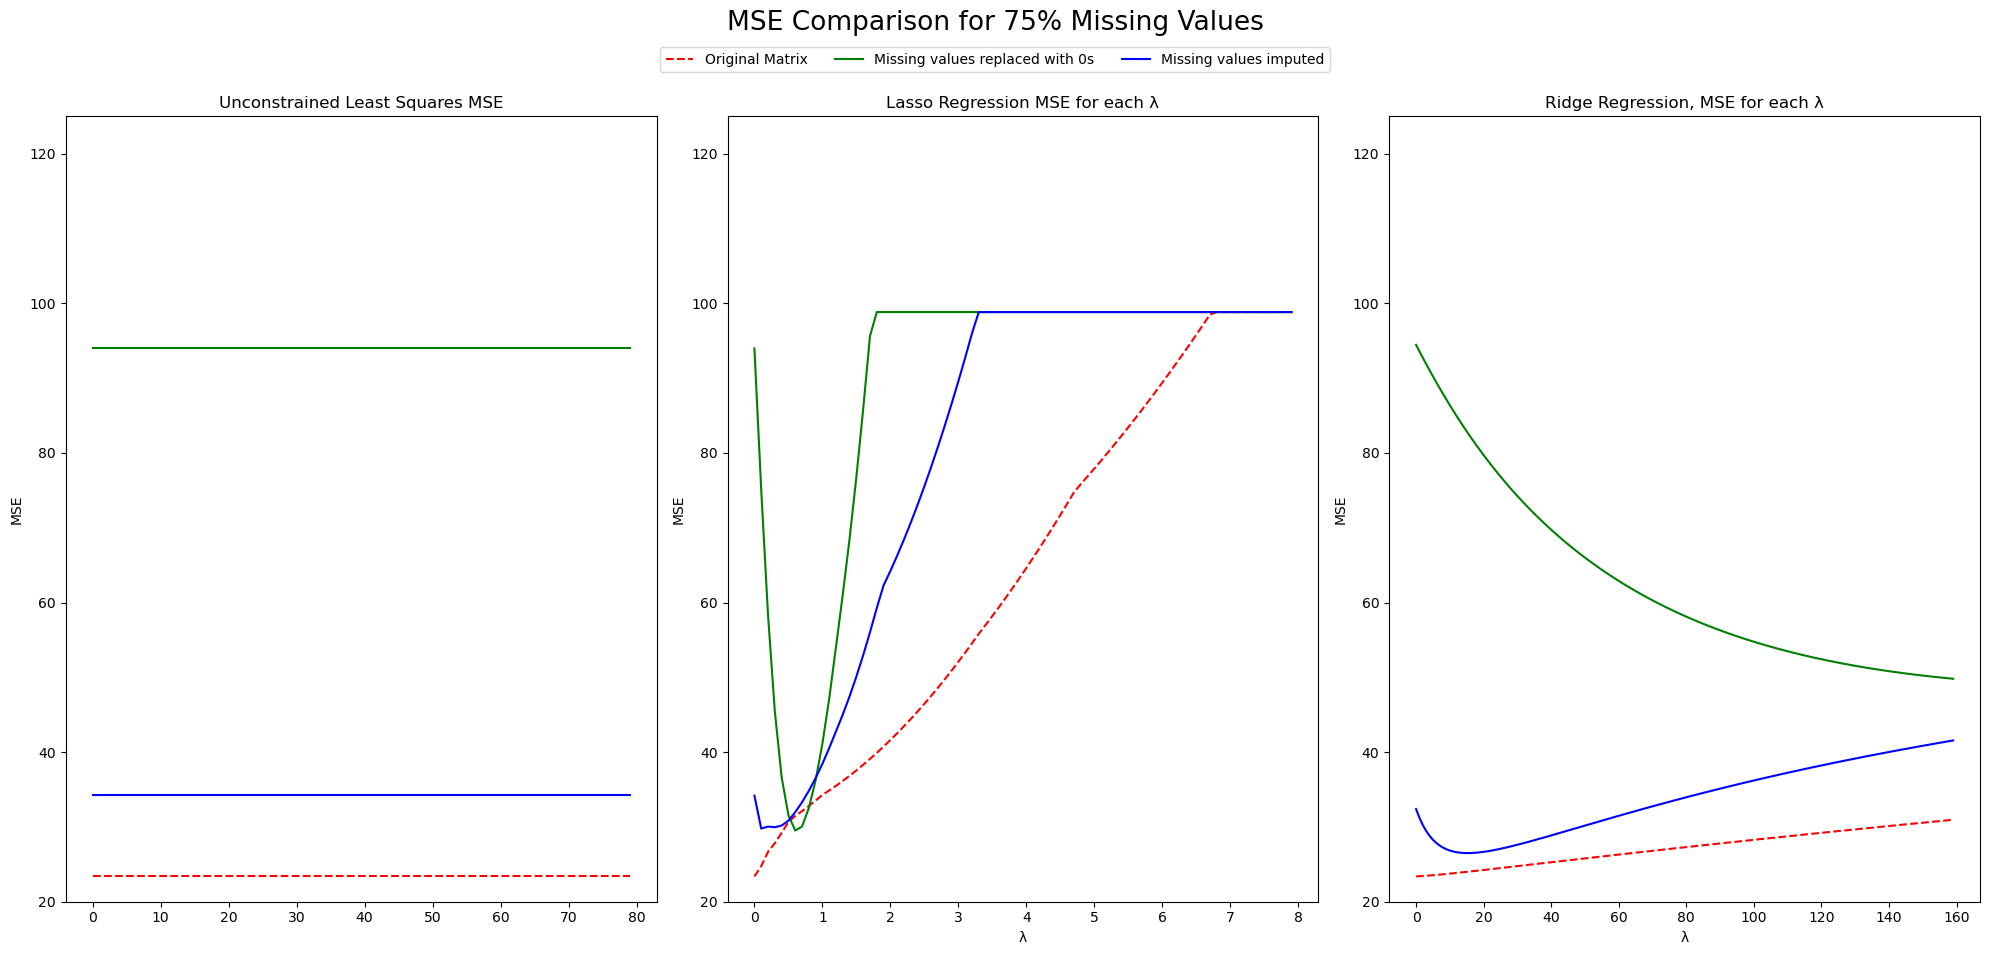

In [29]:
pf.plot_mse_comparisons(mse_ols_100_incremental, mse_ols_75_incremental, mse_ols_75_imputed,
                     mse_lasso_100_incremental, mse_lasso_75_incremental, mse_lasso_75_imputed,
                     mse_ridge_100_incremental, mse_ridge_75_incremental, mse_ridge_75_imputed,
                     lambdas_lasso_missing, lambdas_ridge, [20, 80], 25)

pf.plot_mse_comparisons(mse_ols_100_incremental, mse_ols_50_incremental, mse_ols_50_imputed,
                     mse_lasso_100_incremental, mse_lasso_50_incremental, mse_lasso_50_imputed,
                     mse_ridge_100_incremental, mse_ridge_50_incremental, mse_ridge_50_imputed,
                     lambdas_lasso_missing, lambdas_ridge, [20, 80], 50)

pf.plot_mse_comparisons(mse_ols_100_incremental, mse_ols_25_incremental, mse_ols_25_imputed,
                     mse_lasso_100_incremental, mse_lasso_25_incremental, mse_lasso_25_imputed,
                     mse_ridge_100_incremental, mse_ridge_25_incremental, mse_ridge_25_imputed,
                     lambdas_lasso_missing, lambdas_ridge, [20, 125], 75)

We see that the nuclear norm method for data imputation, is able to significantly reduce the MSE of the reconstruction, for all the datasets and all the models.
The lasso regression, seems to be the most robust model, as it is able to keep the MSE relatively low, even for the 75% missing values' dataset for both the naively replace with 0s and the imputed datasets.
We should also note that for the 75% missing values dataset, the Ridge Regression is finally able to outperform the Unconstrained Least Squares regression, for bigger lambda values.

Let's now impute the values for all the sparse datasets, and plot the MSE of the reconstruction for each model.

In [30]:
# run nuclear norm imputation for each dataset
lambdas = np.arange(0, 8, 0.1)

mse_ols_75_imputed = cf.nuclear_norm_imputation(dataset_75_incremental_original, X_train, lambdas)
mse_ols_50_imputed = cf.nuclear_norm_imputation(dataset_50_incremental_original, X_train, lambdas)
mse_ols_25_imputed = cf.nuclear_norm_imputation(dataset_25_incremental_original, X_train, lambdas)

100%|██████████| 80/80 [00:03<00:00, 24.32it/s]


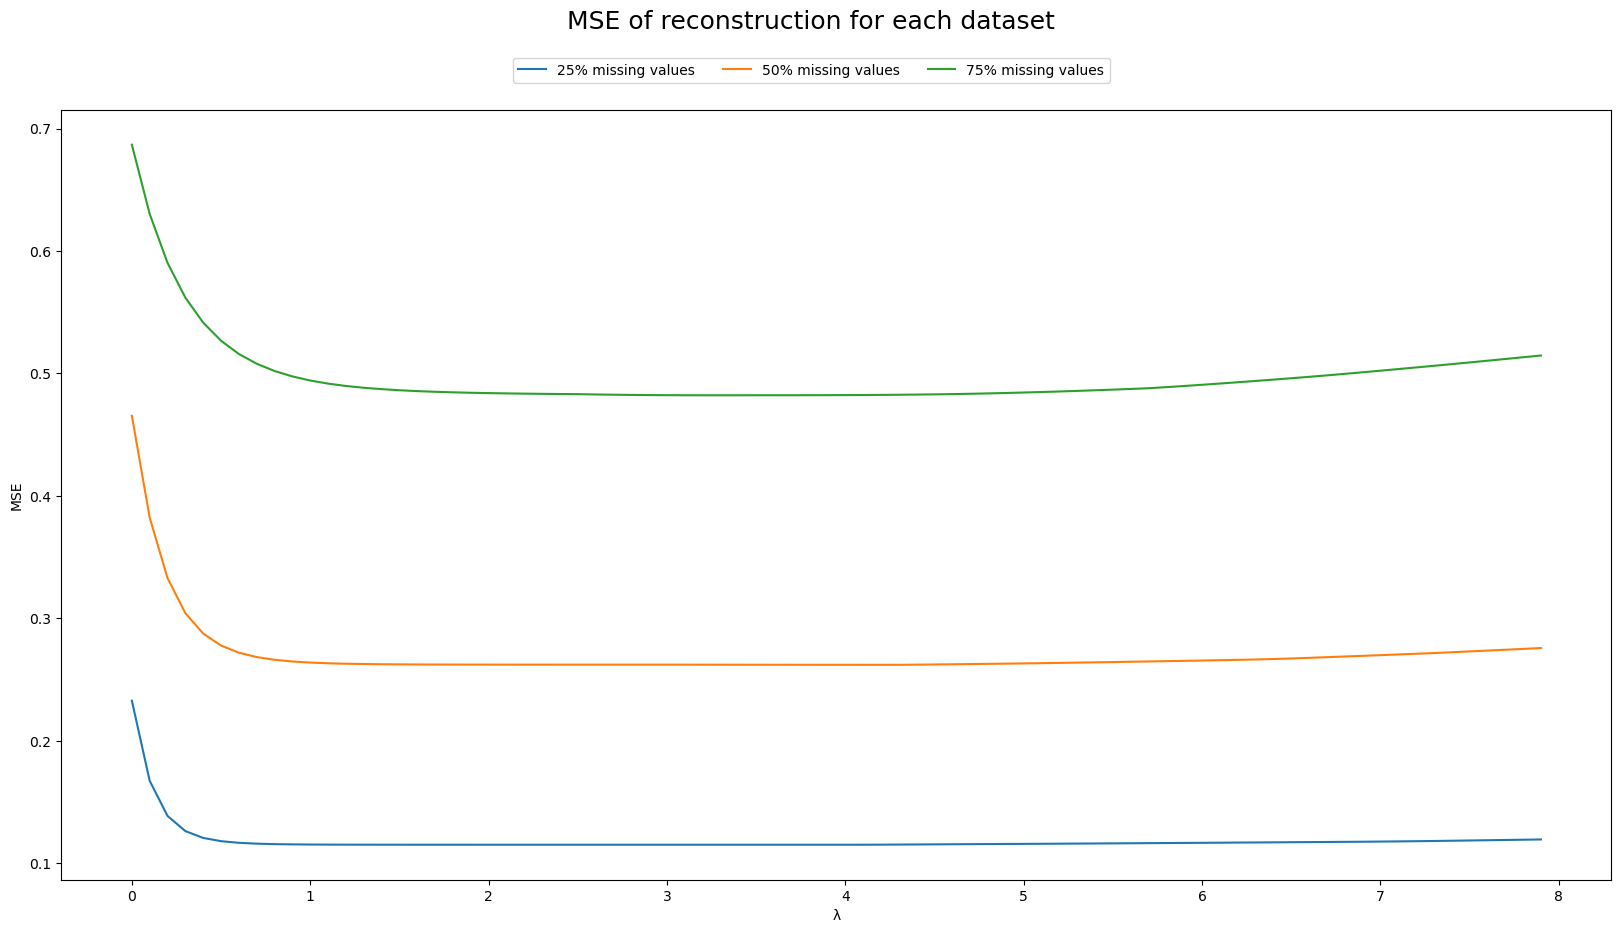

In [31]:
# plot the mse of each dataset in one plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

axes.plot(lambdas, mse_ols_75_imputed)
axes.plot(lambdas, mse_ols_50_imputed)
axes.plot(lambdas, mse_ols_25_imputed)
fig.suptitle('MSE of reconstruction for each dataset', fontsize=18)
axes.set_xlabel('λ')
axes.set_ylabel('MSE')
fig.legend(['25% missing values', '50% missing values', '75% missing values'], loc='lower center', bbox_to_anchor=(0.5, 0.9), ncol=3)

plt.show()

## Conclusion
In this notebook, we have explored various aspects of the Boston Housing dataset through comprehensive data analysis and modeling. We implemented and compared three different regression models, investigated the impact of missing data, and applied advanced imputation techniques. Our findings highlight the strengths and weaknesses of each regression model and demonstrate the effectiveness of the nuclear norm method in handling missing data.

This analysis not only provides insights into the specific dataset but also offers broader lessons on the robustness of regression models and the importance of proper data handling techniques in machine learning. Future work could explore additional models, feature engineering techniques, or alternative imputation methods to further enhance our understanding of these complex interactions.